### Synthetic Data Generation for Credit Card Default Prediction
### Input data is unbalanced wherein data population value for target(output) is 78% vs 22%
### Since this problem statement call out for predicting credit card defaulter (target = 1) but data value patterns is fairly less in the put data
### 6 Compartive analysis have been considered to generate synthetic data required to furnish Machine Learning model for correct prediction
### NOGAN Synthetic Data generation has outperform accuracy score compared to other 5 approaches

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Understand the data
##### This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.
##### Every transaction value is in New Taiwan(NT) Dollars
##### What column name conveys-
##### ID - Id of each client
##### LIMIT_BAL - Amount of given credit in NT dollars(includes individual and family/supplementary credit)
##### SEX -
######  1 - male
###### 2 - female
##### EDUCATION -
###### 1 - Graduate school
###### 2 - University
###### 3 - High school
###### 4 - others
###### 5 - Unknown
##### MARRIAGE - Martial status
###### 1 - Married
###### 2 - single
###### 3 - Others
##### AGE - Age in years
##### PAY_0 - September repayment status
###### -2 - No consumption
##### -1 - pay duly
##### 0 - Use of revolving credit
##### 1 - payment delay one month
##### 2 - payment delay for two months
##### 3 - payment delay for three months
##### 8 - payment delay for eight months
##### 9 - payment delay for nine months or above
##### PAY_2 - August repayment status(same code)
##### PAY_3 - July repayment status(same code)
##### PAY_4 - June repayment status(same code)
##### PAY_5 - May repayment status(same code)
##### PAY 6 - April repayment status(same code)
##### BILL_AMT1 - September Bill statement
##### BILL_AMT2 - August Bill Statement
##### BILL_AMT3 - July Bill Statement
##### BILL_AMT4 - June Bill Statement
##### BILL_AMT5 - May Bill Statement
##### BIll_AMT6 - April Bill Statement
##### PAY_AMT1 - Amount of previous payment in September
##### PAY_AMT2 - Amount of previous payment in August
##### PAY_AMT3 - "" "" "" "" "" July
##### PAY_AMT4 - "" "" "" "" "" June
##### PAY_AMT5 - "" "" "" "" "" May
##### PAY_AMT6 - "" "" "" "" "" April
##### default.payment.next.month - Default payment
###### 1 - yes
###### 0 - No

## 1) NOGAN - SYNTHETIC DATASET GENERATION

## Installing Python Modules

In [2]:
!pip install genai_evaluation
!pip install nogan_synthesizer
!pip install flatten_dict
#!pip install sdv

### Importing Python package

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import genai_evaluation as ge
from genai_evaluation import multivariate_ecdf, ks_statistic
import nogan_synthesizer as ns
from nogan_synthesizer import NoGANSynth
from nogan_synthesizer.preprocessing import wrap_category_columns, unwrap_category_columns
from modules import utils, models
from sklearn.metrics import mean_absolute_error, accuracy_score
from timeit import default_timer as timer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import ks_2samp, wasserstein_distance
from flatten_dict import flatten

### Validating Python Version

In [ ]:
print(f"Pandas Version: {pd.__version__}")
print(f"NUmpy Version: {np.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"GenAI Version: {ge.__version__}")
print(f"NoGAN Synthesizer Version: {ns.__version__}")

Pandas Version: 2.0.3
NUmpy Version: 1.24.3
Seaborn Version: 0.12.2
Matplotlib Version: 3.7.2
GenAI Version: 0.1.5
NoGAN Synthesizer Version: 0.1.5


### Loading Input Data

In [2]:
data = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
data.columns = data.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
data.columns = data.columns.str.replace('default.payment.next.month', 'target')

In [18]:
data.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


### Renaming Output attribute

In [19]:
data.columns = data.columns.str.replace('default.payment.next.month', 'target')

 Graphical representation for Unbalance data


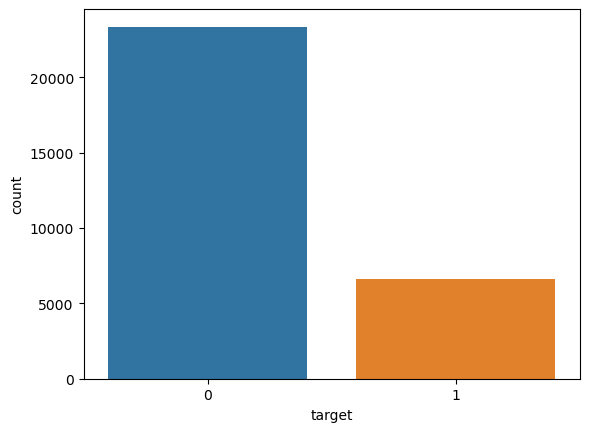

In [20]:
sns.countplot(
    data = data, x='target')

print(f" Graphical representation for Unbalance data")

In [21]:
print(f"Data Shape: {data.shape}")
data.info()

Data Shape: (30000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         30000 non-null  int64  
 1   limit_bal  30000 non-null  float64
 2   sex        30000 non-null  int64  
 3   education  30000 non-null  int64  
 4   marriage   30000 non-null  int64  
 5   age        30000 non-null  int64  
 6   pay_0      30000 non-null  int64  
 7   pay_2      30000 non-null  int64  
 8   pay_3      30000 non-null  int64  
 9   pay_4      30000 non-null  int64  
 10  pay_5      30000 non-null  int64  
 11  pay_6      30000 non-null  int64  
 12  bill_amt1  30000 non-null  float64
 13  bill_amt2  30000 non-null  float64
 14  bill_amt3  30000 non-null  float64
 15  bill_amt4  30000 non-null  float64
 16  bill_amt5  30000 non-null  float64
 17  bill_amt6  30000 non-null  float64
 18  pay_amt1   30000 non-null  float64
 19  pay_amt2   30000 non-n

In [89]:
import sdv

### Defining Metadata using SDV Python Module

In [90]:
from sdv.metadata import SingleTableMetadata
import pandas as pd
metadata = SingleTableMetadata()
df_test = data
metadata.detect_from_dataframe(df_test)
metadata

{
    "primary_key": "id",
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "id": {
            "sdtype": "id"
        },
        "limit_bal": {
            "sdtype": "numerical"
        },
        "sex": {
            "sdtype": "categorical"
        },
        "education": {
            "sdtype": "categorical"
        },
        "marriage": {
            "sdtype": "categorical"
        },
        "age": {
            "sdtype": "numerical"
        },
        "pay_0": {
            "sdtype": "numerical"
        },
        "pay_2": {
            "sdtype": "numerical"
        },
        "pay_3": {
            "sdtype": "numerical"
        },
        "pay_4": {
            "sdtype": "numerical"
        },
        "pay_5": {
            "sdtype": "numerical"
        },
        "pay_6": {
            "sdtype": "numerical"
        },
        "bill_amt1": {
            "sdtype": "numerical"
        },
        "bill_amt2": {
            "sdtype": "numerical"
        },
 

### Segregating Numeric and Category columns based on Metadata information
#### Dataframe is unbalanced having largely populated for target = 0
#### Creating filtered dataframe with target = 1 to generate synthetic data

In [22]:
data = data.drop(data[data["target"] == 0].index)

features = [
  'id',
  'limit_bal',
  'sex',
  'education',
  'marriage',
  'age',
  'pay_0',
  'pay_2',
  'pay_3',
  'pay_4',
  'pay_5',
  'pay_6',
  'bill_amt1',
  'bill_amt2',
  'bill_amt3',
  'bill_amt4',
  'bill_amt5',
  'bill_amt6',
  'pay_amt1',
  'pay_amt2',
  'pay_amt3',
  'pay_amt4',
  'pay_amt5',
  'pay_amt6',
  'target'
]

target_column = 'target'

cat_cols = ['sex', 'education', 'marriage', 'target','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'
            ]

num_cols = [f for f in features if f not in cat_cols]

data_s = data[features]
print(f"Data Shape: {data_s.shape}")

Data Shape: (6636, 25)


### Preprocessing for Synthetic Data generation

In [23]:
# Stratified Test Split to make sure the target columns are distributed well in the train & test split

training_data, validation_data = \
          utils.stratified_train_test_split(data,
                                            target_column = target_column,
                                            train_size=1

                                            )

print(f"Data Shape: {data.shape}\nTraining Shape: {training_data.shape}\nValidation Shape: {validation_data.shape}")

Data Shape: (6636, 25)
Training Shape: (6636, 25)
Validation Shape: (0, 25)


In [24]:
training_data.columns = training_data.columns.str.replace(' ','')

In [25]:
wrapped_train_data, idx_to_key_train, key_to_idx_train = \
                    wrap_category_columns(training_data,cat_cols)

#wrapped_val_data, idx_to_key_val, key_to_idx_val = \
                    #wrap_category_columns(validation_data,cat_cols)

print(f"Data Shape: {data.shape}\n Preprocessed Training Shape: {wrapped_train_data.shape}")

Data Shape: (6636, 25)
 Preprocessed Training Shape: (6636, 16)


In [30]:
wrapped_train_data.head()

,id,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,cat_label
0,25159,30000.0,22,22623.0,3019.0,-341.0,1129.0,1470.0,339.0,10.0,0.0,1470.0,341.0,0.0,12324.0,1
1,424,200000.0,38,104978.0,105924.0,102663.0,97090.0,98045.0,105253.0,4500.0,0.0,3500.0,3500.0,9000.0,0.0,2
2,24574,50000.0,35,48047.0,46593.0,46945.0,21260.0,70.0,29575.0,0.0,2052.0,1800.0,0.0,29935.0,1200.0,3
3,4555,160000.0,48,23037.0,22260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,28460,230000.0,35,1214.0,964.0,1214.0,464.0,214.0,-536.0,500.0,1000.0,0.0,500.0,0.0,0.0,5


In [26]:
bins = [100] * len(wrapped_train_data.columns)
#stretch  = [-1] * len(wrapped_train_data.columns)

# bins = [41, 251, 11, 31, 31, 11, 31, 21, 61, 41, 131, 361, 81, 11, 1, 421, 321, 451, 351, 11, 40]

In [27]:
#from random import seed
nogan = NoGANSynth(wrapped_train_data,random_seed=None)
start_time = timer()
nogan.fit()
wrapped_nogan_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True #,
                                                         #stretch = stretch
                                                         )
end_time = timer()
nogan_training_time = end_time - start_time
print(wrapped_train_data.shape, wrapped_nogan_synth_data.shape)

List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(6636, 16) (6636, 16)


### Synthetic Data Generation for target = 1

In [28]:
wrapped_nogan_synth_data.info()
print(f"wrapped_data Shape: {wrapped_nogan_synth_data.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6636 non-null   int32  
 1   limit_bal  6636 non-null   float64
 2   age        6636 non-null   int32  
 3   bill_amt1  6636 non-null   float64
 4   bill_amt2  6636 non-null   float64
 5   bill_amt3  6636 non-null   float64
 6   bill_amt4  6636 non-null   float64
 7   bill_amt5  6636 non-null   float64
 8   bill_amt6  6636 non-null   float64
 9   pay_amt1   6636 non-null   float64
 10  pay_amt2   6636 non-null   float64
 11  pay_amt3   6636 non-null   float64
 12  pay_amt4   6636 non-null   float64
 13  pay_amt5   6636 non-null   float64
 14  pay_amt6   6636 non-null   float64
 15  cat_label  6636 non-null   int32  
dtypes: float64(13), int32(3)
memory usage: 751.9 KB
wrapped_data Shape: (6636, 16)


### Organizing  Synthetic Data Generation in the original table structure

In [29]:
nogan_synth_data = unwrap_category_columns(data=wrapped_nogan_synth_data,idx_to_key=idx_to_key_train, cat_cols=cat_cols)

nogan_synth_data = nogan_synth_data[features]
nogan_synth_data.info()
print(nogan_synth_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6636 non-null   int32  
 1   limit_bal  6636 non-null   float64
 2   sex        6636 non-null   int64  
 3   education  6636 non-null   int64  
 4   marriage   6636 non-null   int64  
 5   age        6636 non-null   int32  
 6   pay_0      6636 non-null   int64  
 7   pay_2      6636 non-null   int64  
 8   pay_3      6636 non-null   int64  
 9   pay_4      6636 non-null   int64  
 10  pay_5      6636 non-null   int64  
 11  pay_6      6636 non-null   int64  
 12  bill_amt1  6636 non-null   float64
 13  bill_amt2  6636 non-null   float64
 14  bill_amt3  6636 non-null   float64
 15  bill_amt4  6636 non-null   float64
 16  bill_amt5  6636 non-null   float64
 17  bill_amt6  6636 non-null   float64
 18  pay_amt1   6636 non-null   float64
 19  pay_amt2   6636 non-null   float64
 20  pay_amt3

### Exporting Synthetic Data generated

In [ ]:
nogan_synth_data.head()
nogan_synth_data.to_csv("NOGAN_synth_data.csv")

### Concatenating Synthetic Data with original data for target = 1

In [ ]:
df_joint = pd.concat([data,nogan_synth_data],axis=0)

### Exporting combined output

In [ ]:
df_joint.to_csv("Combine_data.csv")

### Original dataset is imbalanced having only 22% population for target = 1
### Repeat the process to generate more synthetic data for target = 1

In [ ]:
data_new = df_joint

features_n = [
  'id',
  'limit_bal',
  'sex',
  'education',
  'marriage',
  'age',
  'pay_0',
  'pay_2',
  'pay_3',
  'pay_4',
  'pay_5',
  'pay_6',
  'bill_amt1',
  'bill_amt2',
  'bill_amt3',
  'bill_amt4',
  'bill_amt5',
  'bill_amt6',
  'pay_amt1',
  'pay_amt2',
  'pay_amt3',
  'pay_amt4',
  'pay_amt5',
  'pay_amt6',
  'target'
]

target_column = 'target'

cat_cols = ['sex', 'education', 'marriage', 'target','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'
            ]

num_cols = [f for f in features_n if f not in cat_cols]

data_new_1 = data_new[features_n]
print(f"Data Shape: {data_new_1.shape}")


Data Shape: (13272, 25)


In [ ]:
# Stratified Test Split to make sure the target columns are distributed well in the train & test split
training_data_n, validation_data_n = \
          utils.stratified_train_test_split(data_new_1,
                                            target_column = target_column,
                                            train_size=.62,
                                            random_state = None
                                            )

print(f"Data Shape: {data_new_1.shape}\nTraining Shape: {training_data_n.shape}\nValidation Shape: {validation_data_n.shape}")

Data Shape: (13272, 25)
Training Shape: (10068, 25)
Validation Shape: (6148, 25)


In [ ]:
training_data_n.to_csv("training_data_n.csv")
data_new_1.to_csv("data_new_1.csv")

In [ ]:
wrapped_train_data_n, idx_to_key_train_n, key_to_idx_train_n = \
                    wrap_category_columns(training_data_n,cat_cols)


print(f"Data Shape: {data_new_1.shape}\n Preprocessed Training Shape: {wrapped_train_data_n.shape}")

Data Shape: (13272, 25)
 Preprocessed Training Shape: (10068, 16)


In [ ]:
nogan_n = NoGANSynth(wrapped_train_data_n,random_seed=None)
start_time = timer()
nogan_n.fit()
wrapped_nogan_synth_data_n = nogan_n.generate_synthetic_data(len(wrapped_train_data_n),
                                                         debug = True #,
                                                         #stretch = stretch
                                                         )
end_time = timer()
nogan_training_time = end_time - start_time
print(wrapped_train_data_n.shape, wrapped_nogan_synth_data_n.shape)

List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(10068, 16) (10068, 16)


In [ ]:
nogan_synth_data_n = unwrap_category_columns(data=wrapped_nogan_synth_data_n,idx_to_key=idx_to_key_train_n, cat_cols=cat_cols)

nogan_synth_data_n = nogan_synth_data_n[features_n]
nogan_synth_data_n.info()
print(nogan_synth_data_n.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10068 entries, 0 to 10067
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10068 non-null  int32  
 1   limit_bal  10068 non-null  float64
 2   sex        10068 non-null  int64  
 3   education  10068 non-null  int64  
 4   marriage   10068 non-null  int64  
 5   age        10068 non-null  int32  
 6   pay_0      10068 non-null  int64  
 7   pay_2      10068 non-null  int64  
 8   pay_3      10068 non-null  int64  
 9   pay_4      10068 non-null  int64  
 10  pay_5      10068 non-null  int64  
 11  pay_6      10068 non-null  int64  
 12  bill_amt1  10068 non-null  float64
 13  bill_amt2  10068 non-null  float64
 14  bill_amt3  10068 non-null  float64
 15  bill_amt4  10068 non-null  float64
 16  bill_amt5  10068 non-null  float64
 17  bill_amt6  10068 non-null  float64
 18  pay_amt1   10068 non-null  float64
 19  pay_amt2   10068 non-null  float64
 20  pay_am

### Concatenating Synthetic Data with previous data for target = 1

In [ ]:
df_joint_upt = pd.concat([df_joint,nogan_synth_data_n],axis=0)

In [ ]:
df_joint_upt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23340 entries, 0 to 10067
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         23340 non-null  int64  
 1   limit_bal  23340 non-null  float64
 2   sex        23340 non-null  int64  
 3   education  23340 non-null  int64  
 4   marriage   23340 non-null  int64  
 5   age        23340 non-null  int64  
 6   pay_0      23340 non-null  int64  
 7   pay_2      23340 non-null  int64  
 8   pay_3      23340 non-null  int64  
 9   pay_4      23340 non-null  int64  
 10  pay_5      23340 non-null  int64  
 11  pay_6      23340 non-null  int64  
 12  bill_amt1  23340 non-null  float64
 13  bill_amt2  23340 non-null  float64
 14  bill_amt3  23340 non-null  float64
 15  bill_amt4  23340 non-null  float64
 16  bill_amt5  23340 non-null  float64
 17  bill_amt6  23340 non-null  float64
 18  pay_amt1   23340 non-null  float64
 19  pay_amt2   23340 non-null  float64
 20  pay_amt3   

### Creating Original datasset again
#### Merging Synthetic data for target = 1 with original dataset for target =1
#### Exporting final dataset

In [ ]:
df_org = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
df_org.columns = df_org.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
df_org.columns = df_org.columns.str.replace('default.payment.next.month', 'target')

In [ ]:
df_org_0= df_org[df_org["target"] == 0]

In [ ]:
df_final = pd.concat([df_org_0,df_joint_upt],axis=0)

In [ ]:
df_final.info()
df_final.to_csv('data/UCI_Credit_Card_NOGAN.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 46704 entries, 2 to 10067
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         46704 non-null  int64  
 1   limit_bal  46704 non-null  float64
 2   sex        46704 non-null  int64  
 3   education  46704 non-null  int64  
 4   marriage   46704 non-null  int64  
 5   age        46704 non-null  int64  
 6   pay_0      46704 non-null  int64  
 7   pay_2      46704 non-null  int64  
 8   pay_3      46704 non-null  int64  
 9   pay_4      46704 non-null  int64  
 10  pay_5      46704 non-null  int64  
 11  pay_6      46704 non-null  int64  
 12  bill_amt1  46704 non-null  float64
 13  bill_amt2  46704 non-null  float64
 14  bill_amt3  46704 non-null  float64
 15  bill_amt4  46704 non-null  float64
 16  bill_amt5  46704 non-null  float64
 17  bill_amt6  46704 non-null  float64
 18  pay_amt1   46704 non-null  float64
 19  pay_amt2   46704 non-null  float64
 20  pay_amt3   

## 2) SDV - SYNTHETIC DATASET GENERATION

### Installing SDV Python Module

In [3]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.6 MB/s eta 0:00:00


### Importing Python Module

In [6]:
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

### Importing original csv datafile into dataframe

In [7]:
df_sdv = pd.read_csv("/content/UCI_Credit_Card.csv",encoding_errors="ignore")
df_sdv.columns = df_sdv.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
df_sdv.columns = df_sdv.columns.str.replace('default.payment.next.month', 'target')
df_sdv.head(2)


<ipython-input-7-d91636e7991f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sdv.columns = df_sdv.columns.str.replace('default.payment.next.month', 'target')


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


### Filter out unbalanced data for target = 1
#### This dataframe would be used to generate synthetic data

In [8]:
df_sdv_1 = df_sdv[df_sdv['target'] == 1]

### Generating Metadata

In [9]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_sdv_1)

### Synthetic data generation to match data population with target = 0

In [10]:
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_sdv_1)

synthetic_data = synthesizer.sample(num_rows=17028)
synthetic_data.index.name = 'id'

In [11]:
synthetic_data.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,143150.0,1,1,2,32,-1,0,0,2,...,98867.0,90890.0,67424.0,1353.0,6299.0,2700.0,920.0,4.0,2409.0,1
1,1,318777.0,2,2,2,40,3,2,1,3,...,192095.0,154869.0,174543.0,11.0,7099.0,3633.0,4.0,583.0,4921.0,1
2,2,178475.0,1,2,1,38,1,-1,0,2,...,17831.0,21143.0,10044.0,949.0,293.0,153.0,2938.0,0.0,2.0,1
3,3,35388.0,1,1,1,60,1,-1,-2,2,...,-5255.0,5316.0,-86.0,0.0,984.0,3.0,0.0,293.0,0.0,1
4,4,77428.0,2,2,1,31,-1,0,1,3,...,65576.0,42991.0,33242.0,0.0,1441.0,0.0,27.0,3.0,0.0,1


### Concatenating original dataframe with synthetic data
### Exporting Final combined dataframe

In [14]:
df_joint_sdv = pd.concat([df_sdv,synthetic_data],axis=0)

In [15]:
df_joint_sdv.info()
df_joint_sdv.to_csv("/content/UCI_credit_card_sdv.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47028 entries, 0 to 17027
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         47028 non-null  int64  
 1   limit_bal  47028 non-null  float64
 2   sex        47028 non-null  int64  
 3   education  47028 non-null  int64  
 4   marriage   47028 non-null  int64  
 5   age        47028 non-null  int64  
 6   pay_0      47028 non-null  int64  
 7   pay_2      47028 non-null  int64  
 8   pay_3      47028 non-null  int64  
 9   pay_4      47028 non-null  int64  
 10  pay_5      47028 non-null  int64  
 11  pay_6      47028 non-null  int64  
 12  bill_amt1  47028 non-null  float64
 13  bill_amt2  47028 non-null  float64
 14  bill_amt3  47028 non-null  float64
 15  bill_amt4  47028 non-null  float64
 16  bill_amt5  47028 non-null  float64
 17  bill_amt6  47028 non-null  float64
 18  pay_amt1   47028 non-null  float64
 19  pay_amt2   47028 non-null  float64
 20  pay_am

## 3) SMOTE - SYNTHETIC DATASET GENERATION

### Installing SMOTE Python Module

In [ ]:
!pip install imblearn

### Importing Python Module

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

### Importing csv datafile

In [ ]:
df_original = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
df_original.columns = df_sdv.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
df_original.columns = df_sdv.columns.str.replace('default.payment.next.month', 'target')
df_original.head(2)

### Creating copy of original dataframe

In [ ]:
df_smt = df_original.copy()
df_smt.head()

### Generating Synethetic data using SMOTE

In [ ]:
oversample = SMOTE()
X_input , y_output = df_smt[:,:-1],df_smt[['target']]
X,y = oversample.fit_resample(X_input,y_output)
print('Shape of X {}'.format(X.shape))
print('Shape of y {}'.format(y.shape))
df_smt = pd.concat([X,y],axis=1)
print('Normal distributed dataset shape {}'.format(df_smt.shape))

In [ ]:
oversample = SMOTE()
X_input , y_output = df_smote[['LIMIT_BAL','ID','SEX','EDUCATION','MARRIAGE','AGE','code_repayment_sept','code_repayment_aug','code_repayment_july','code_repayment_june','code_repayment_may','code_repayment_april','bill_sept','bill_aug','bill_july','bill_may','bill_april','previous_payment_sept','previous_payment_aug','previous_payment_july','previous_payment_june','previous_payment_may','previous_payment_april']],df_smote[['will_default']]
#X_input , y_output = df_smote[['LIMIT_BAL','ID','SEX','EDUCATION','MARRIAGE','AGE','code_repayment_sept','code_repayment_aug','code_repayment_july','code_repayment_june','code_repayment_may','code_repayment_april','bill_sept','bill_aug','bill_july']],df_smote[['will_default']]
X_input = X_input.replace({0: 1})
X,y = oversample.fit_resample(X_input,y_output)
print('Shape of X {}'.format(X.shape))
print('Shape of y {}'.format(y.shape))
df_smote = pd.concat([X,y],axis=1)
print('Normal distributed dataset shape {}'.format(df_smote.shape))

In [ ]:
df_smote.info()
df_smote.to_csv("data/UCI_credit_card_smote.csv")

## Comparitive Evaluation Original vs NOGAN vs SDV vs SMOTE

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import genai_evaluation as ge
from genai_evaluation import multivariate_ecdf, ks_statistic
import nogan_synthesizer as ns
from nogan_synthesizer import NoGANSynth
from nogan_synthesizer.preprocessing import wrap_category_columns, unwrap_category_columns

from modules import utils
from sklearn.metrics import mean_absolute_error, accuracy_score

from timeit import default_timer as timer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing Original, Synthetic - NOGAN , Synthetic - SDV, Synthetic - SMOTE

In [4]:
df_original = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
df_original.columns = df_original.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
df_original.columns = df_original.columns.str.replace('default.payment.next.month', 'target')
df_original.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


In [37]:
df_nogan = pd.read_csv("data/UCI_Credit_Card_NOGAN.csv",encoding_errors="ignore")
df_nogan.pop(df_nogan.columns[0])
df_nogan.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,3,"90,000.0000",2,2,2,34,0,0,0,0,...,"14,331.0000","14,948.0000","15,549.0000","1,518.0000","1,500.0000","1,000.0000","1,000.0000","1,000.0000","5,000.0000",0
1,4,"50,000.0000",2,2,1,37,0,0,0,0,...,"28,314.0000","28,959.0000","29,547.0000","2,000.0000","2,019.0000","1,200.0000","1,100.0000","1,069.0000","1,000.0000",0


In [36]:
df_sdv = pd.read_csv("data/UCI_Credit_Card_sdv.csv",encoding_errors="ignore")
df_sdv.pop(df_sdv.columns[0])
df_sdv.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,1,"20,000.0000",2,2,1,24,2,2,-1,-1,...,0.0000,0.0000,0.0000,0.0000,689.0000,0.0000,0.0000,0.0000,0.0000,1
1,2,"120,000.0000",2,2,2,26,-1,2,0,0,...,"3,272.0000","3,455.0000","3,261.0000",0.0000,"1,000.0000","1,000.0000","1,000.0000",0.0000,"2,000.0000",1


In [38]:
df_smote = pd.read_csv("data/UCI_Credit_Card_smote.csv",encoding_errors="ignore")
df_smote.pop(df_smote.columns[0])
df_smote.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,1,"20,000.0000",2,2,1,24,2,2,-1,-1,...,0.0000,0.0000,0.0000,0.0000,689.0000,0.0000,0.0000,0.0000,0.0000,1
1,2,"120,000.0000",2,2,2,26,-1,2,0,0,...,"3,272.0000","3,455.0000","3,261.0000",0.0000,"1,000.0000","1,000.0000","1,000.0000",0.0000,"2,000.0000",1


### Plot with 2 variables after PCA reduction

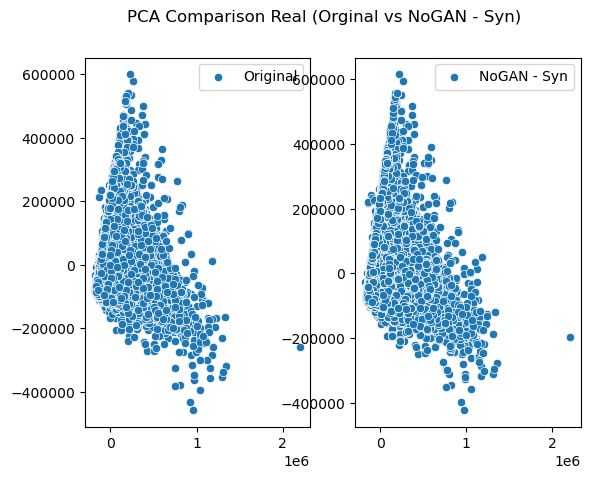

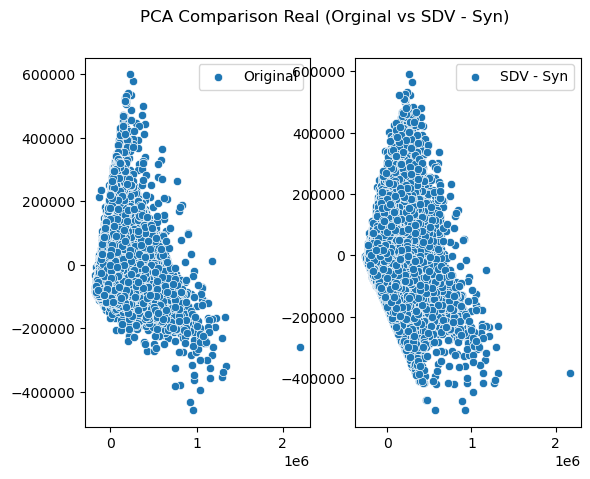

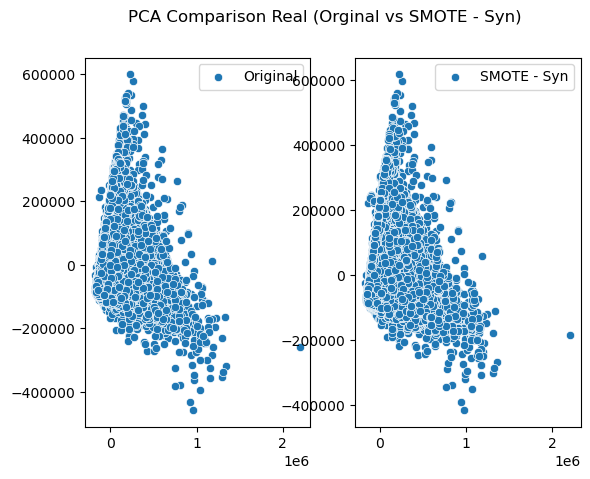

In [16]:
utils.plot_pca_comparison(df_original, 
                          df_nogan, 
                          df_a_name = "Original",
                          df_b_name = "NoGAN - Syn",     
                          title = "PCA Comparison Real (Orginal vs NoGAN - Syn)")

utils.plot_pca_comparison(df_original, 
                          df_sdv, 
                          df_a_name = "Original",
                          df_b_name = "SDV - Syn",     
                          title = "PCA Comparison Real (Orginal vs SDV - Syn)")

utils.plot_pca_comparison(df_original, 
                          df_smote, 
                          df_a_name = "Original",
                          df_b_name = "SMOTE - Syn",     
                          title = "PCA Comparison Real (Orginal vs SMOTE - Syn)")

##### Results
Cleary evident that NoGAN outperforms SDV and SMOTE having maximum similarity quotient with original data

### Segregating Numeric and Categorical Metadata for Graphical comparison

In [24]:
features = [
  'id',
  'limit_bal',
  'sex',
  'education',
  'marriage',
  'age',
  'pay_0',
  'pay_2',
  'pay_3',
  'pay_4',
  'pay_5',
  'pay_6',
  'bill_amt1',
  'bill_amt2',
  'bill_amt3',
  'bill_amt4',
  'bill_amt5',
  'bill_amt6',
  'pay_amt1',
  'pay_amt2',
  'pay_amt3',
  'pay_amt4',
  'pay_amt5',
  'pay_amt6',
  'target'
]

target_column = 'target'
id_cols = ['id']
cat_cols = ['sex', 'education', 'marriage', 'target','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'
            ]

num_cols = [f for f in features if f not in cat_cols]
num_cols_n = [x for x in num_cols if x not in id_cols]
num_cols_n_1 = ['limit_bal', 'age','bill_amt1','bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6']
num_cols_n_2 = [ 'pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']


### KDE plots NoGAN vs Original Dataset

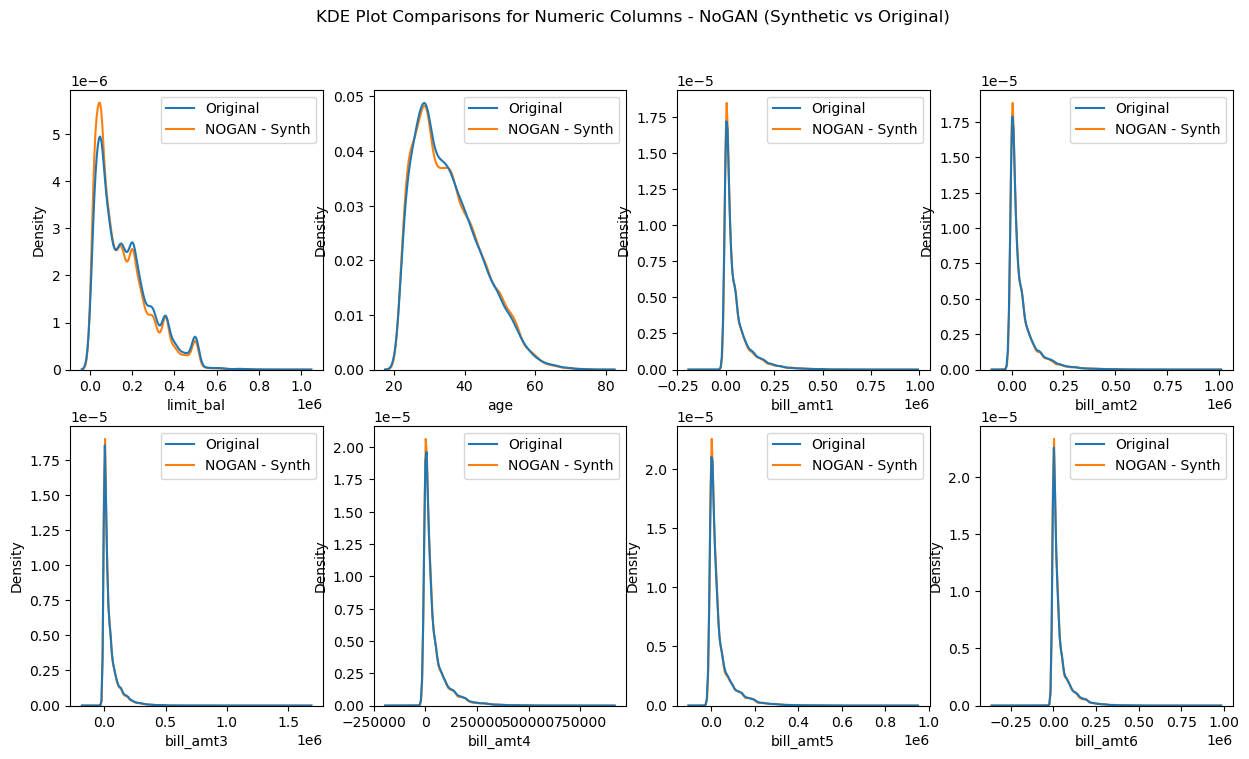

In [29]:
plot_features = num_cols_n_1
#plot_features = list(nogan_synth_data.columns)
#plot_features.remove("target")
sd = df_nogan
vd = df_original

utils.plot_density_comparison(
                                vd, 
                                sd, 
                                df_a_name = "Original",
                                df_b_name = "NOGAN - Synth",                                
                                features = plot_features, 
                                title = "KDE Plot Comparisons for Numeric Columns - NoGAN (Synthetic vs Original)")


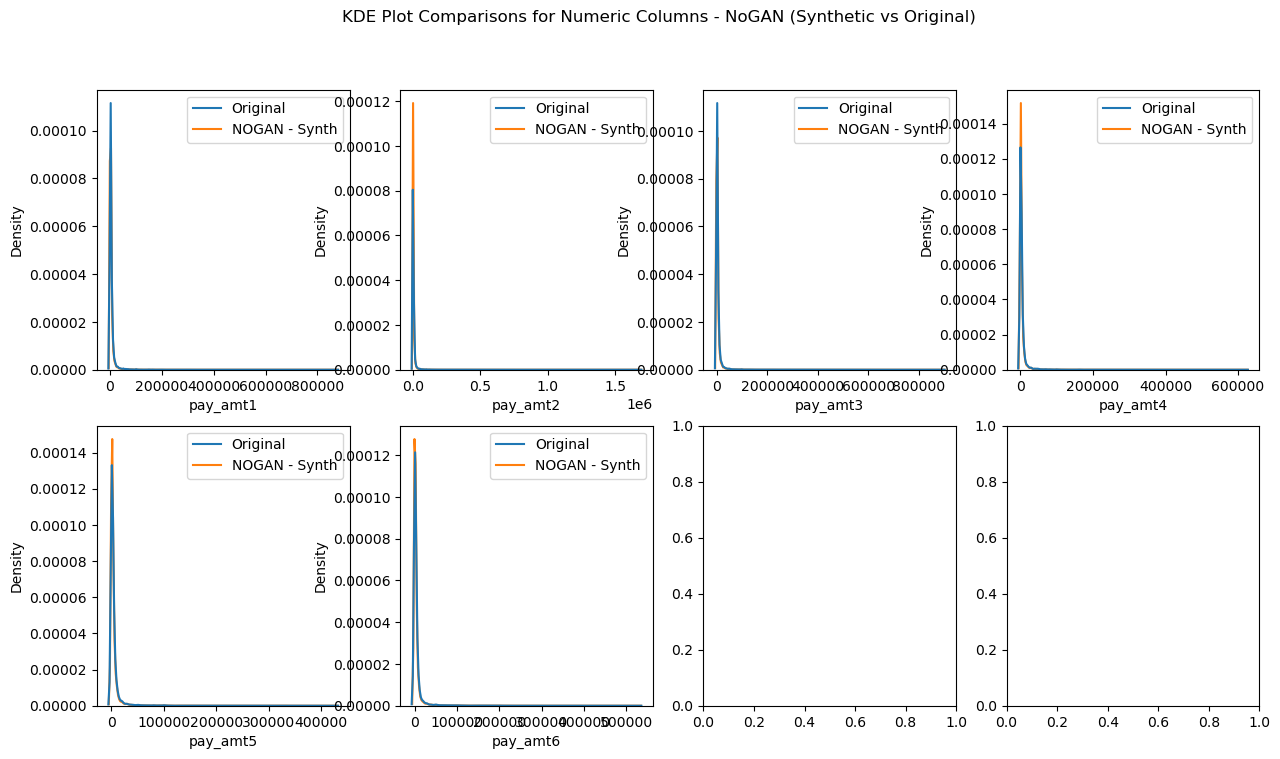

In [31]:
plot_features = num_cols_n_2
#plot_features = list(nogan_synth_data.columns)
#plot_features.remove("target")
sd = df_nogan
vd = df_original

utils.plot_density_comparison(
                                vd, 
                                sd, 
                                df_a_name = "Original",
                                df_b_name = "NOGAN - Synth",                                
                                features = plot_features, 
                                title = "KDE Plot Comparisons for Numeric Columns - NoGAN (Synthetic vs Original)")

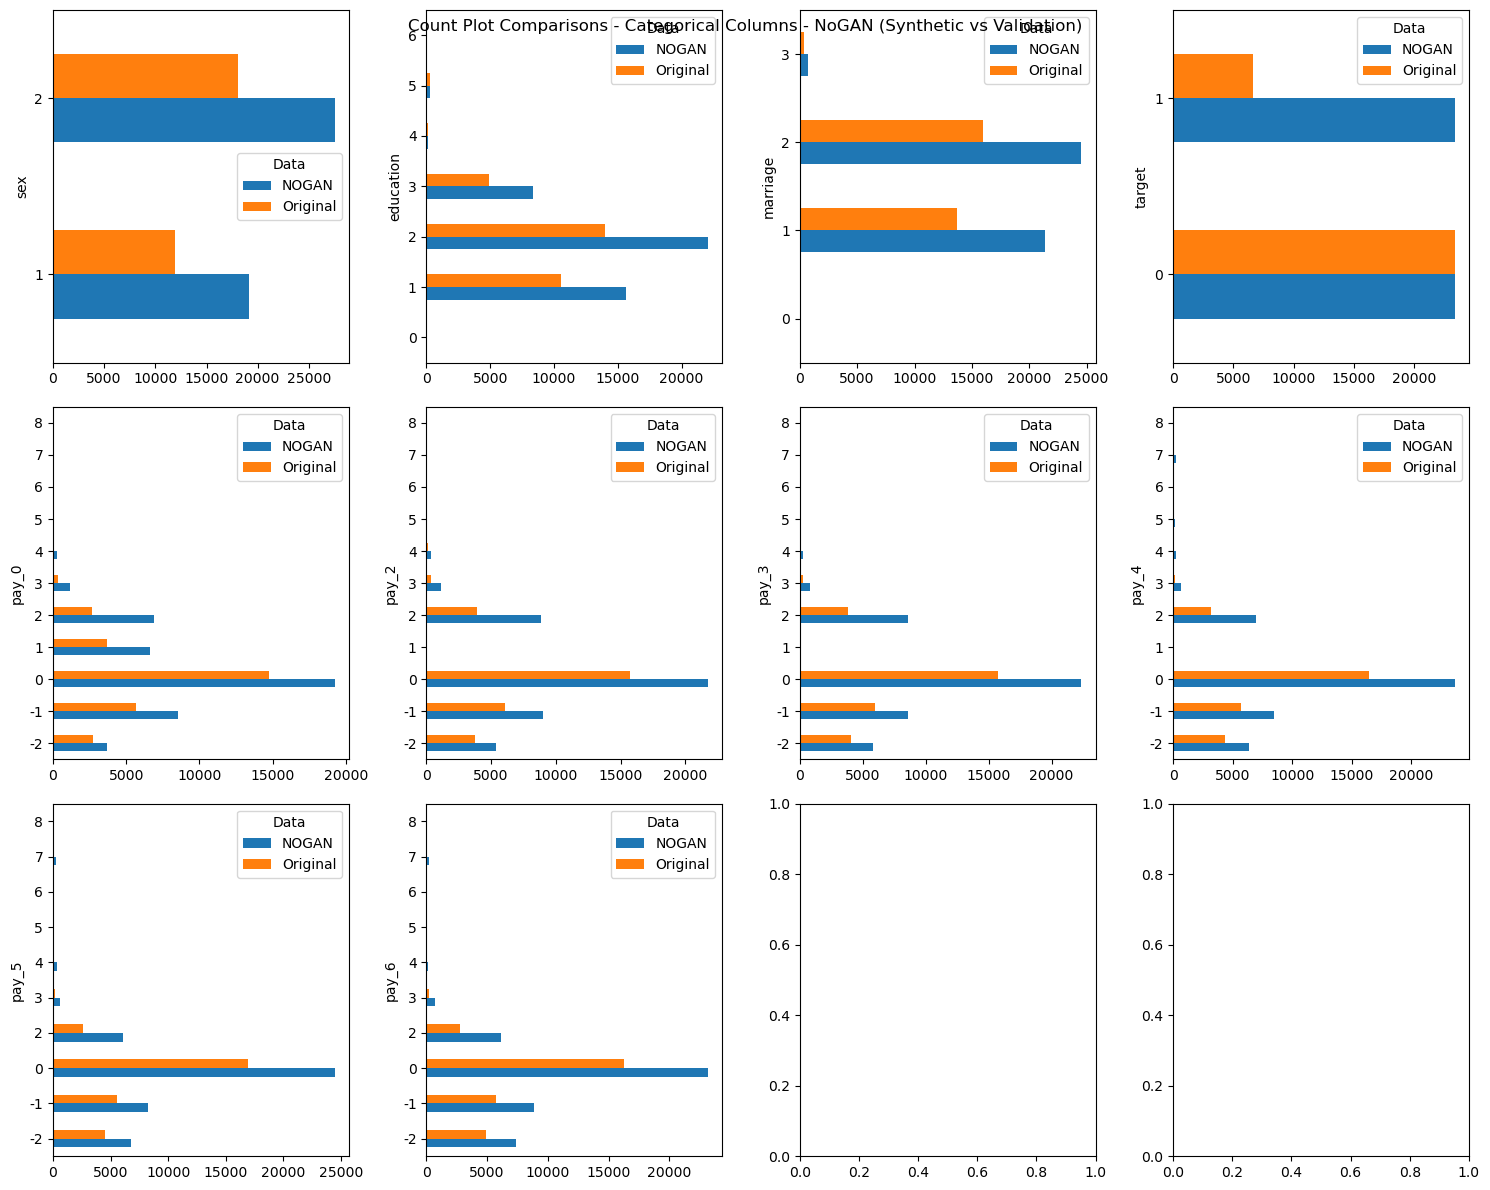

In [34]:
cat_plot_features = cat_cols.copy()
vd = df_original[cat_plot_features]
sd = df_nogan[cat_plot_features]

utils.plot_count_comparison(vd, 
                            sd,
                           
                                df_a_name = "Original",
                                df_b_name = "NOGAN",

                                features = cat_plot_features,
                            
                                title = "Count Plot Comparisons - Categorical Columns - NoGAN (Synthetic vs Validation)")

### KDE plots SDV vs Original Dataset

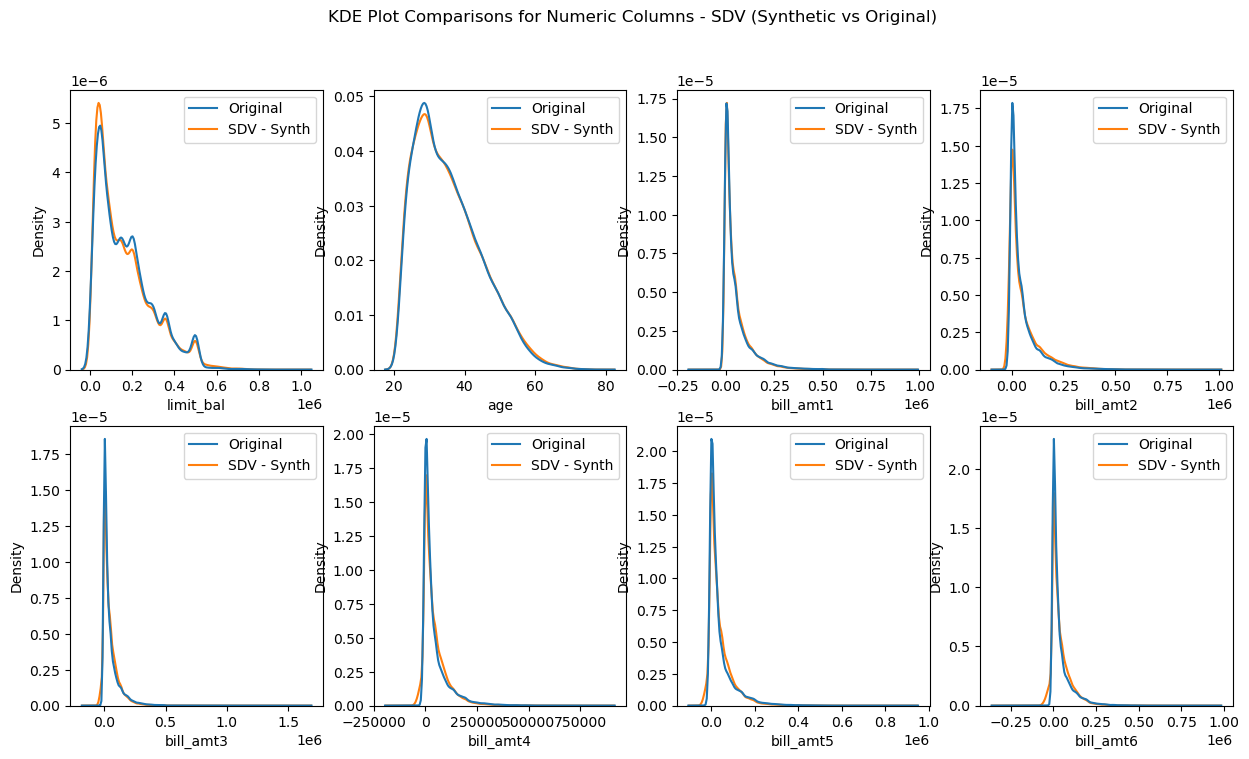

In [36]:
plot_features = num_cols_n_1

sd = df_sdv
vd = df_original

utils.plot_density_comparison(
                                vd, 
                                sd, 
                                df_a_name = "Original",
                                df_b_name = "SDV - Synth",                                
                                features = plot_features, 
                                title = "KDE Plot Comparisons for Numeric Columns - SDV (Synthetic vs Original)")


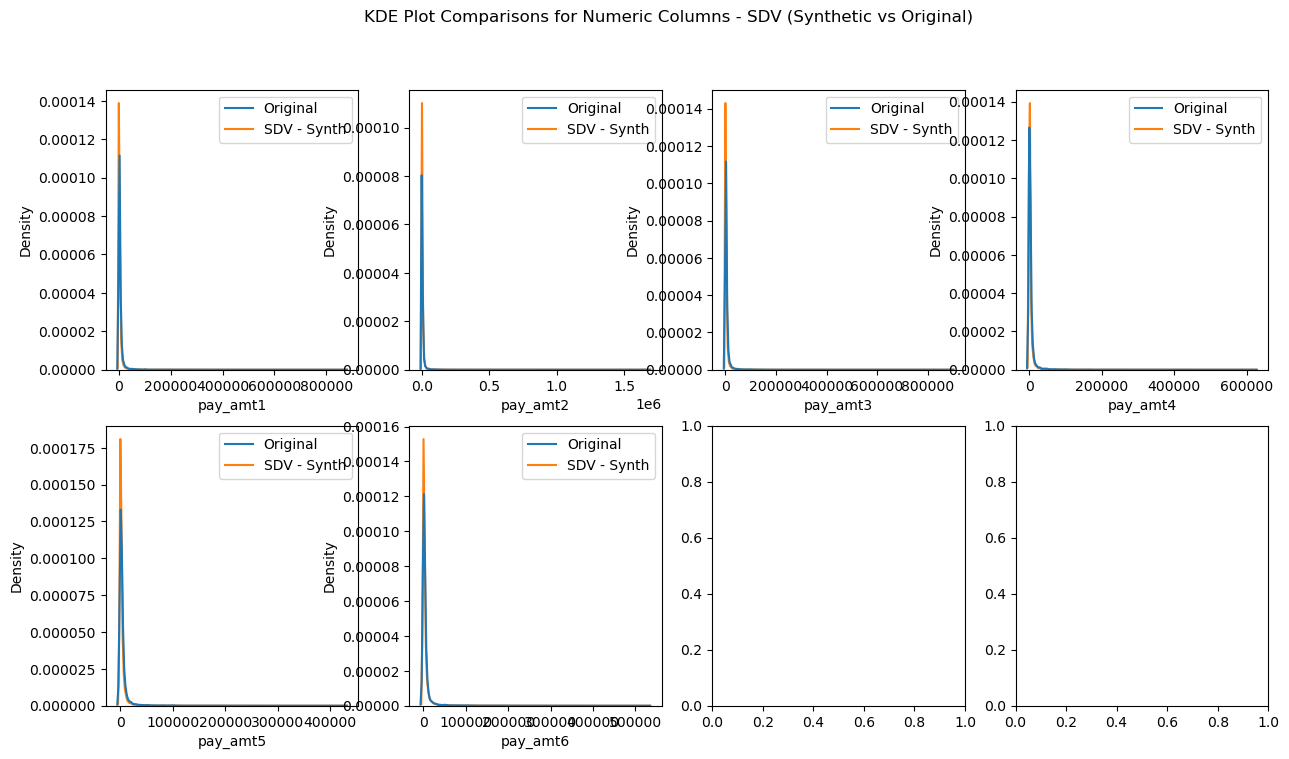

In [37]:
plot_features = num_cols_n_2
sd = df_sdv
vd = df_original

utils.plot_density_comparison(
                                vd, 
                                sd, 
                                df_a_name = "Original",
                                df_b_name = "SDV - Synth",                                
                                features = plot_features, 
                                title = "KDE Plot Comparisons for Numeric Columns - SDV (Synthetic vs Original)")


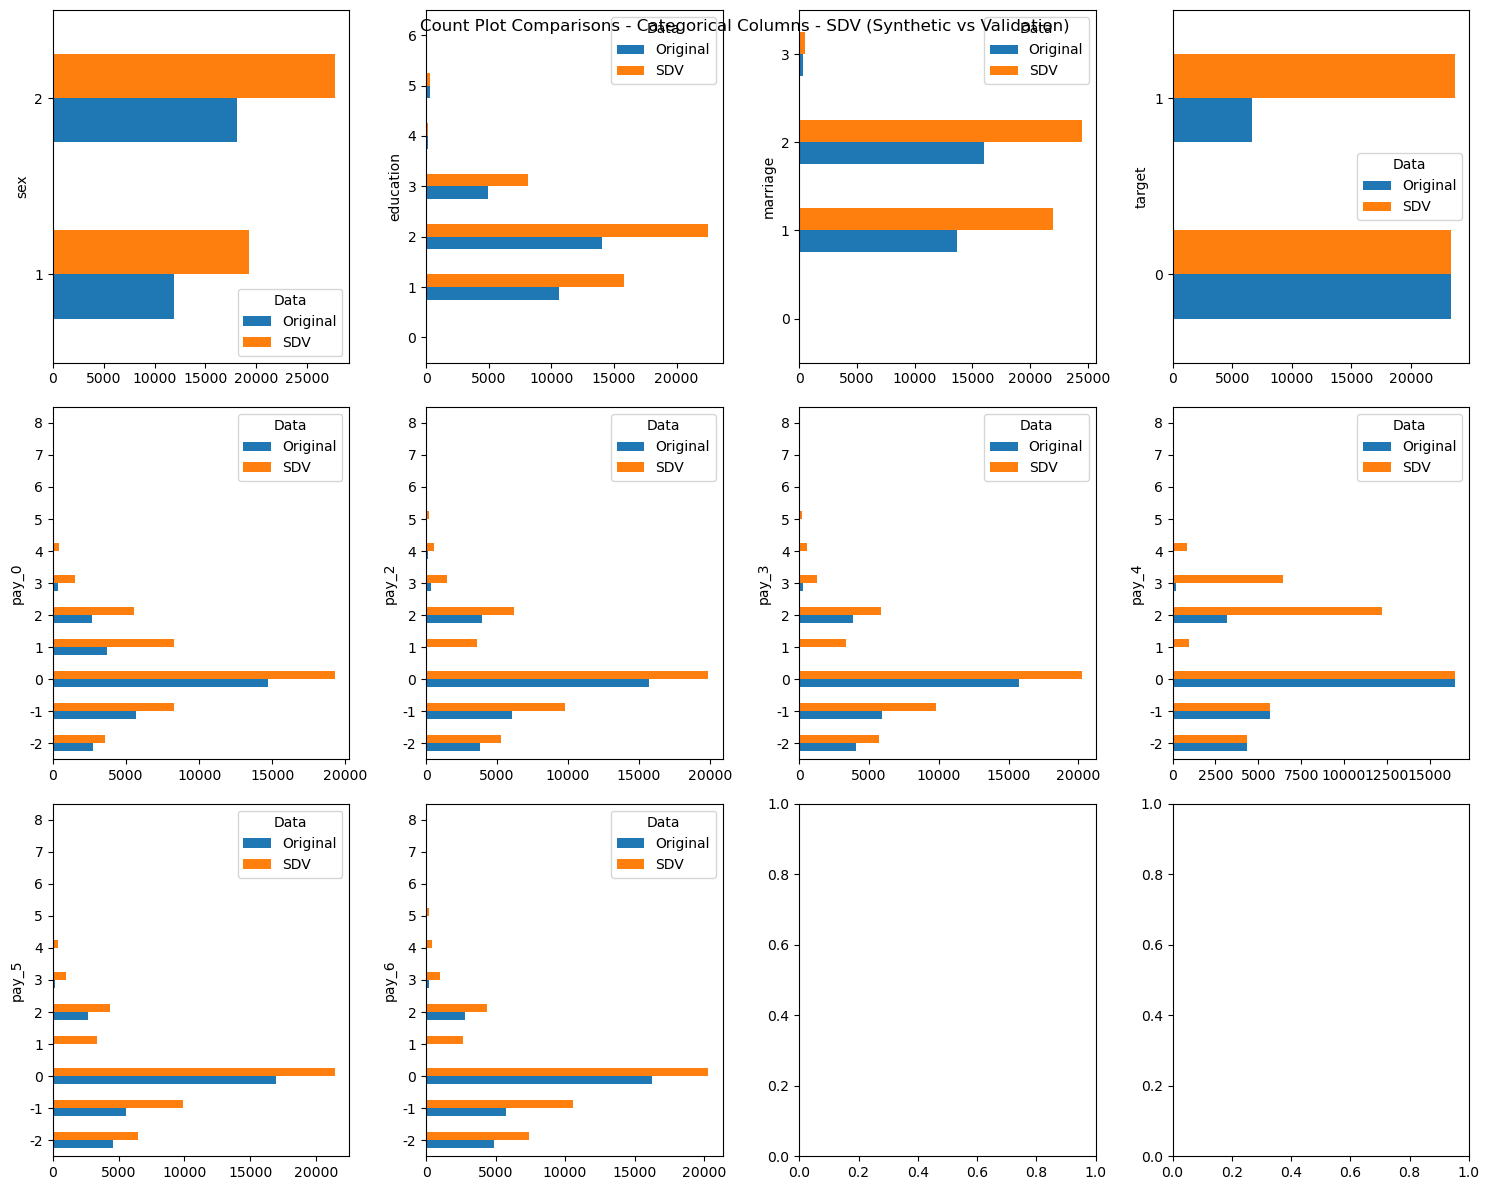

In [38]:
cat_plot_features = cat_cols.copy()
vd = df_original[cat_plot_features]
sd = df_sdv[cat_plot_features]

utils.plot_count_comparison(vd, 
                            sd,
                           
                                df_a_name = "Original",
                                df_b_name = "SDV",

                                features = cat_plot_features,
                            
                                title = "Count Plot Comparisons - Categorical Columns - SDV (Synthetic vs Validation)")

### KDE plots SMOTE vs Original Dataset

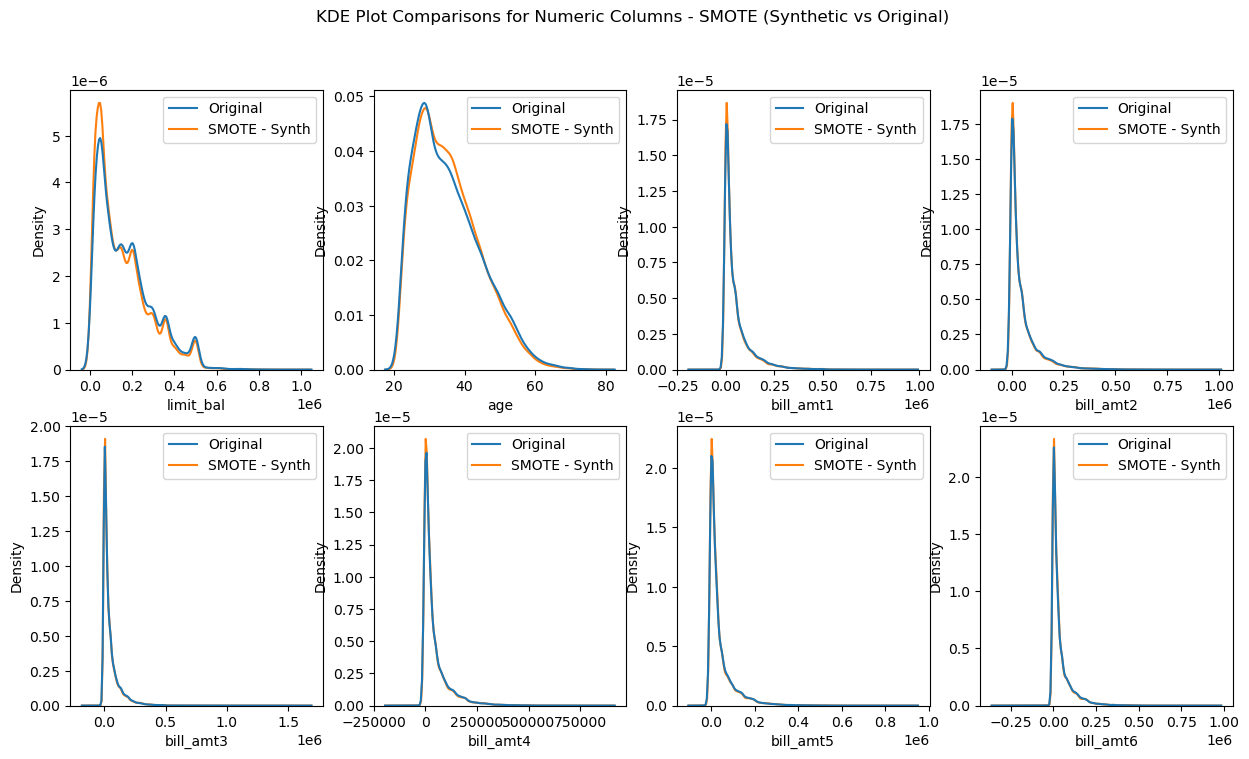

In [39]:
plot_features = num_cols_n_1

sd = df_smote
vd = df_original

utils.plot_density_comparison(
                                vd, 
                                sd, 
                                df_a_name = "Original",
                                df_b_name = "SMOTE - Synth",                                
                                features = plot_features, 
                                title = "KDE Plot Comparisons for Numeric Columns - SMOTE (Synthetic vs Original)")


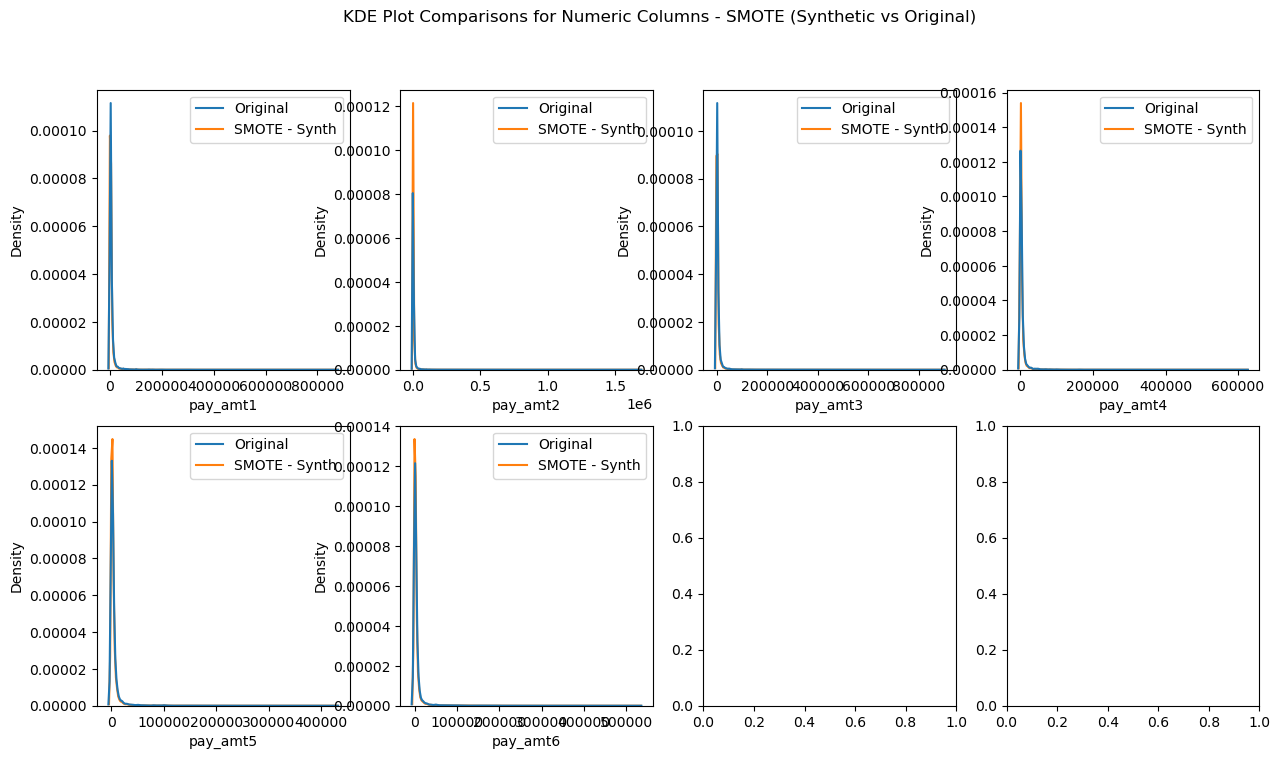

In [40]:
plot_features = num_cols_n_2

sd = df_smote
vd = df_original

utils.plot_density_comparison(
                                vd, 
                                sd, 
                                df_a_name = "Original",
                                df_b_name = "SMOTE - Synth",                                
                                features = plot_features, 
                                title = "KDE Plot Comparisons for Numeric Columns - SMOTE (Synthetic vs Original)")


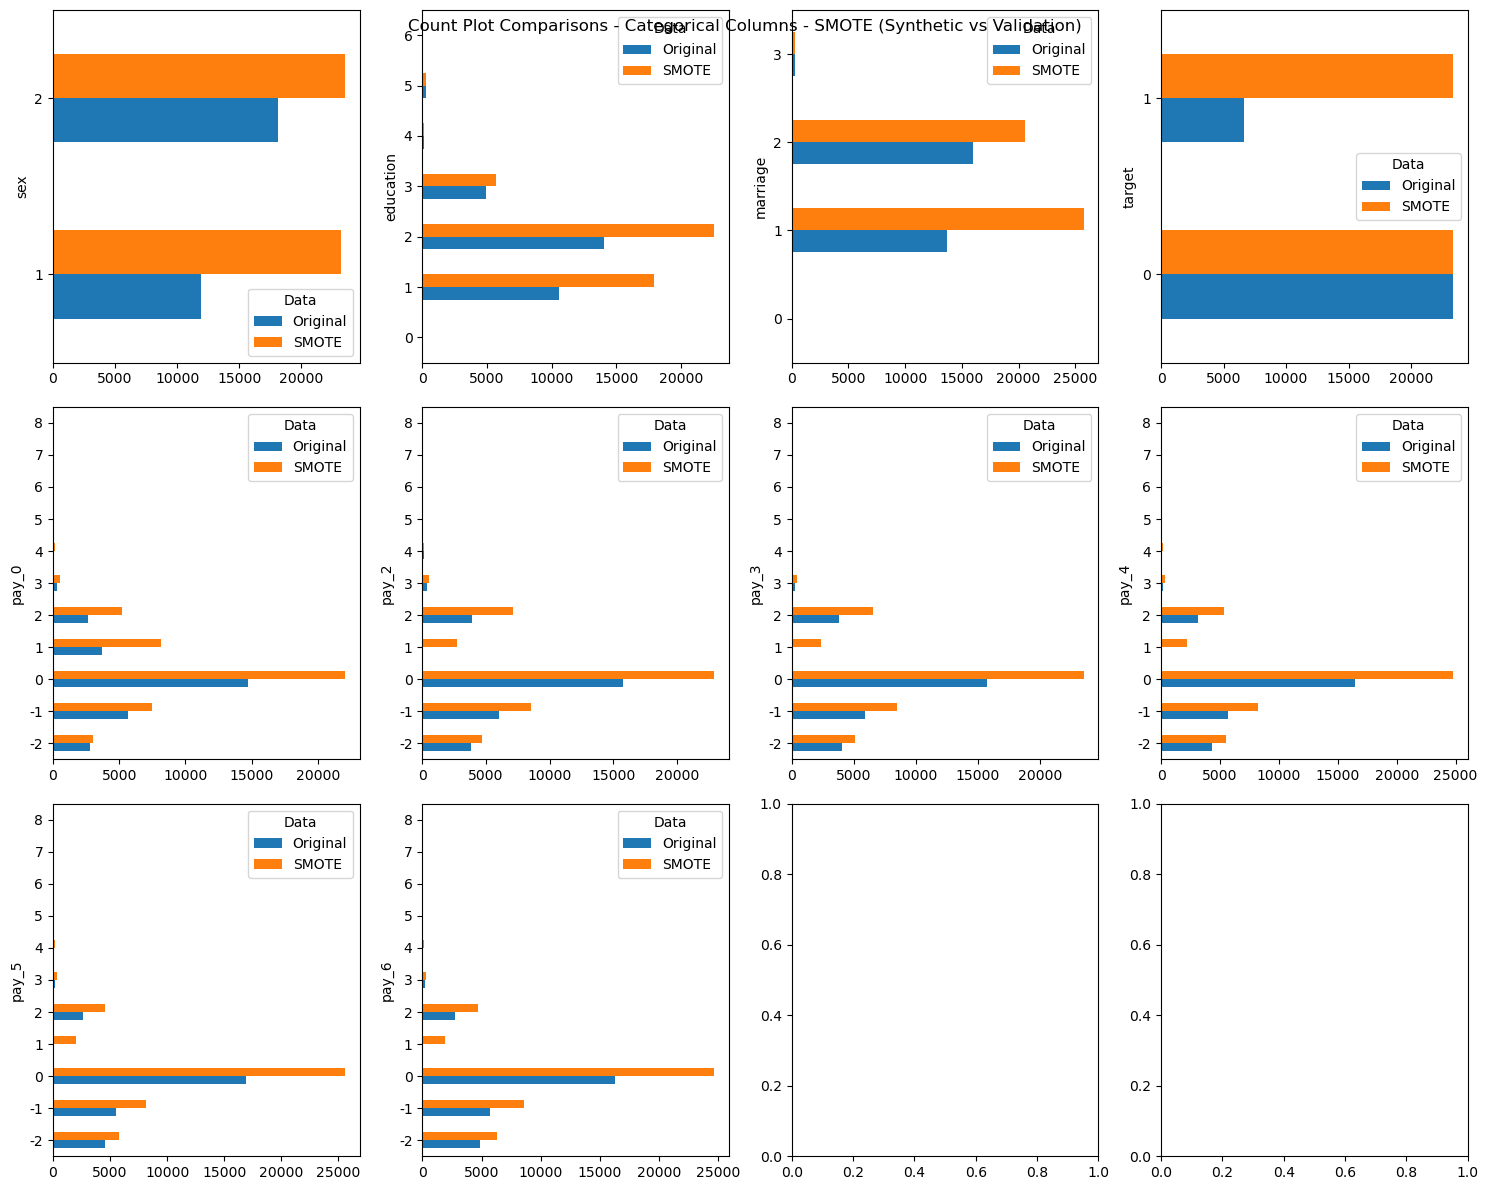

In [41]:
cat_plot_features = cat_cols.copy()
vd = df_original[cat_plot_features]
sd = df_smote[cat_plot_features]

utils.plot_count_comparison(vd, 
                            sd,
                           
                                df_a_name = "Original",
                                df_b_name = "SMOTE",

                                features = cat_plot_features,
                            
                                title = "Count Plot Comparisons - Categorical Columns - SMOTE (Synthetic vs Validation)")

### Validating Metadata

In [43]:
from sdv.metadata import SingleTableMetadata
import pandas as pd
metadata = SingleTableMetadata()
df_test = df_original
metadata.detect_from_dataframe(df_test)
metadata

{
    "columns": {
        "id": {
            "sdtype": "id"
        },
        "limit_bal": {
            "sdtype": "numerical"
        },
        "sex": {
            "sdtype": "categorical"
        },
        "education": {
            "sdtype": "categorical"
        },
        "marriage": {
            "sdtype": "categorical"
        },
        "age": {
            "sdtype": "numerical"
        },
        "pay_0": {
            "sdtype": "numerical"
        },
        "pay_2": {
            "sdtype": "numerical"
        },
        "pay_3": {
            "sdtype": "numerical"
        },
        "pay_4": {
            "sdtype": "numerical"
        },
        "pay_5": {
            "sdtype": "numerical"
        },
        "pay_6": {
            "sdtype": "numerical"
        },
        "bill_amt1": {
            "sdtype": "numerical"
        },
        "bill_amt2": {
            "sdtype": "numerical"
        },
        "bill_amt3": {
            "sdtype": "numerical"
        },
      

#### Similarity Score Between Original vs NOGAN

In [44]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(df_original, df_nogan,metadata)
print(f"'Quality Report for Original vs NoGAN: {quality_report}")

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.88it/s]

Overall Quality Score: 95.73%

Properties:
- Column Shapes: 95.47%
- Column Pair Trends: 95.99%
'Quality Report for Original vs NoGAN: <sdmetrics.reports.single_table.quality_report.QualityReport object at 0x000002250EA6E910>


#### Similarity Score Between Original vs SDV

In [45]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(df_original, df_sdv,metadata)
print(f"'Quality Report for Original vs SDV: {quality_report}")

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.76it/s]

Overall Quality Score: 92.38%

Properties:
- Column Shapes: 89.5%
- Column Pair Trends: 95.25%
'Quality Report for Original vs SDV: <sdmetrics.reports.single_table.quality_report.QualityReport object at 0x00000225052E7A90>


#### Similarity Score Between Original vs SMOTE

In [46]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(df_original, df_smote,metadata)
print(f"'Quality Report for Original vs SMOTE: {quality_report}")

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████| 300/300 [00:24<00:00, 12.32it/s]

Overall Quality Score: 94.72%

Properties:
- Column Shapes: 94.26%
- Column Pair Trends: 95.18%
'Quality Report for Original vs SMOTE: <sdmetrics.reports.single_table.quality_report.QualityReport object at 0x0000022506D41990>


#### Results
Cleary evident that Quality score for NoGAN outperforms SDV and SMOTE

In [45]:
from modules import utils,models

In [55]:
!pip install table_evaluator --upgrade

In [58]:
from table_evaluator import load_data, TableEvaluator

In [59]:
table_evaluator = TableEvaluator(df_original, df_nogan, cat_cols=cat_cols)

In [60]:
table_evaluator

#### Quality Metrics Report - Data Similarity Between Original vs NoGAN

In [62]:
print("********** Evaluation for NoGAN **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_nogan = TableEvaluator(df_original, df_nogan, cat_cols=cat_cols)

table_evaluator_nogan.evaluate(target_col='target')

********** Evaluation for NoGAN **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.8092   0.7660              0.4839
DecisionTreeClassifier_real   0.7357   0.8672              0.5446
LogisticRegression_fake       0.4928   0.6212              0.2430
LogisticRegression_real       0.7862   0.5592              0.3052
MLPClassifier_fake            0.5485   0.6525              0.3164
MLPClassifier_real            0.7687   0.5917              0.3727
RandomForestClassifier_fake   0.7535   0.8438              0.5291
RandomForestClassifier_real   0.8088   0.9120              0.7043

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.2554
nearest neighbor std                     0.7762

Miscellaneous results:
        

####  Quality Metrics Report - Data Similarity Between Original vs SDV

In [104]:
print("********** Evaluation for SDV **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_sdv = TableEvaluator(df_original, df_sdv, cat_cols=cat_cols)

table_evaluator_sdv.evaluate(target_col='target')

********** Evaluation for SDV **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7692   0.8275              0.4728
DecisionTreeClassifier_real   0.7183   0.8567              0.5617
LogisticRegression_fake       0.5092   0.7443              0.3365
LogisticRegression_real       0.7733   0.6565              0.5277
MLPClassifier_fake            0.5360   0.8038              0.4813
MLPClassifier_real            0.7622   0.7578              0.8002
RandomForestClassifier_fake   0.6933   0.8732              0.4509
RandomForestClassifier_real   0.8030   0.8860              0.7539

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.1640
nearest neighbor std                     0.9775

Miscellaneous results:
          

####  Quality Metrics Report - Data Similarity Between Original vs SMOTE

In [64]:
print("********** Evaluation for SMOTE **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_smote = TableEvaluator(df_original, df_smote, cat_cols=cat_cols)

table_evaluator_smote.evaluate(target_col='target')

********** Evaluation for SMOTE **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7725   0.7422              0.4447
DecisionTreeClassifier_real   0.7248   0.8495              0.5330
LogisticRegression_fake       0.5030   0.6218              0.2375
LogisticRegression_real       0.7808   0.5472              0.2925
MLPClassifier_fake            0.5033   0.6368              0.3206
MLPClassifier_real            0.7800   0.6230              0.3899
RandomForestClassifier_fake   0.7190   0.8012              0.5013
RandomForestClassifier_real   0.8067   0.8838              0.6842

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.2930
nearest neighbor std                     0.9987

Miscellaneous results:
        

### Generating Synethetic data using GTGAN

In [3]:
import ctgan
from ctgan import CTGAN

In [4]:
data = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
data.columns = data.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
data.columns = data.columns.str.replace('default.payment.next.month', 'target')

In [5]:
#data = data.drop(data[data["target"] == 0].index)

features = [
  'id',
  'limit_bal',
  'sex',
  'education',
  'marriage',
  'age',
  'pay_0',
  'pay_2',
  'pay_3',
  'pay_4',
  'pay_5',
  'pay_6',
  'bill_amt1',
  'bill_amt2',
  'bill_amt3',
  'bill_amt4',
  'bill_amt5',
  'bill_amt6',
  'pay_amt1',
  'pay_amt2',
  'pay_amt3',
  'pay_amt4',
  'pay_amt5',
  'pay_amt6',
  'target'
]

target_column = 'target'

cat_cols = ['sex', 'education', 'marriage', 'target','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'
            ]

num_cols = [f for f in features if f not in cat_cols]

data_s = data[features]
print(f"Data Shape: {data_s.shape}")

Data Shape: (30000, 25)


In [6]:
# Stratified Test Split to make sure the target columns are distributed well in the train & test split

training_data, validation_data = \
          utils.stratified_train_test_split(data,
                                            target_column = target_column,
                                            train_size=.8

                                            )

print(f"Data Shape: {data.shape}\nTraining Shape: {training_data.shape}\nValidation Shape: {validation_data.shape}")

Data Shape: (30000, 25)
Training Shape: (23999, 25)
Validation Shape: (6001, 25)


In [7]:
training_data.columns = training_data.columns.str.replace(' ','')

In [8]:
wrapped_train_data, idx_to_key_train, key_to_idx_train = \
                    wrap_category_columns(training_data,cat_cols)

wrapped_val_data, idx_to_key_val, key_to_idx_val = \
                    wrap_category_columns(validation_data,cat_cols)

print(f"Data Shape: {data.shape}\n Preprocessed Training Shape: {wrapped_train_data.shape}")

Data Shape: (30000, 25)
 Preprocessed Training Shape: (23999, 16)


In [9]:
bins = [100] * len(wrapped_train_data.columns)
#stretch  = [-1] * len(wrapped_train_data.columns)

# bins = [41, 251, 11, 31, 31, 11, 31, 21, 61, 41, 131, 361, 81, 11, 1, 421, 321, 451, 351, 11, 40]

In [10]:
ctgan = CTGAN(verbose=False)

start_time = timer()
ctgan.fit(training_data, discrete_columns = cat_cols, epochs = 200 )
ctgan_synth_data = ctgan.sample(len(training_data))
end_time = timer()
ctgan_training_time = end_time - start_time

print(ctgan_synth_data.shape)

(23999, 25)


In [24]:

ctgan_synth_data.to_csv('data/ctgan_synth_data.csv')
ctgan_synth_data.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,17415,"91,394.8553",1,1,1,36,4,5,4,2,...,"74,753.4444","220,484.0402","186,565.2900","1,518.4425",923.2874,"3,247.5803",155.8587,"2,600.0803",-245.1203,0
1,2486,"92,306.6276",1,2,1,33,0,0,0,0,...,"106,218.9942","45,419.1634","54,975.4652","3,882.8355","4,928.5573","3,580.2065","8,605.8368",888.2641,"1,928.0951",0


In [12]:
wrapped_ctgan_synth_data, idx_to_key_ctgan_synth, key_to_idx_ctgan_synth = \
                    wrap_category_columns(ctgan_synth_data, cat_cols = cat_cols)
                    
print(wrapped_ctgan_synth_data.shape)

(23999, 16)


In [13]:
df_original = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
df_original.columns = df_original.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
df_original.columns = df_original.columns.str.replace('default.payment.next.month', 'target')

#### Data Similarity Score Between Original vs CTGAN

In [93]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(df_original, ctgan_synth_data,metadata)
print(f"'Quality Report for Original vs CTGAN: {quality_report}")

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 46.03it/s]

Overall Score: 86.68%

Properties:
- Column Shapes: 84.81%
- Column Pair Trends: 88.55%
'Quality Report for Original vs CTGAN: <sdmetrics.reports.single_table.quality_report.QualityReport object at 0x000001F359AF8310>


#### Quality Metrics Report - Data Similarity Between Original vs CTGAN

In [23]:
print("********** Evaluation for CTGAN **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_ctgan = TableEvaluator(df_original, ctgan_synth_data, cat_cols=cat_cols)

table_evaluator_ctgan.evaluate(target_col='target')

********** Evaluation for CTGAN **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6329   0.7221              0.4621
DecisionTreeClassifier_real   0.7308   0.7331              0.5587
LogisticRegression_fake       0.7475   0.7465              0.9258
LogisticRegression_real       0.7840   0.7840              1.0000
MLPClassifier_fake            0.6675   0.7444              0.5673
MLPClassifier_real            0.6794   0.7729              0.5782
RandomForestClassifier_fake   0.7321   0.7956              0.6402
RandomForestClassifier_real   0.8071   0.7987              0.8032

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.7956
nearest neighbor std                     1.3196

Miscellaneous results:
        

### Comparison Between Original vs Synthetic Data generated by YData.ai website 

In [17]:
data_ydata = pd.read_csv("data/UCI_Credit_card_ydata.csv",encoding_errors="ignore")
data_ydata.columns = data_ydata.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
data_ydata.columns = data_ydata.columns.str.replace('default.payment.next.month', 'target')
data_ydata.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,5063,"390,000.0000",2,1,1,32,-2,-2,-2,-2,...,0.0000,0.0000,"77,543.0000",0.0000,396.0000,22.0000,0.0000,"70,500.0000",584.0000,1
1,1860,"10,000.0000",1,3,2,35,0,0,-1,0,...,780.0000,0.0000,0.0000,"1,056.0000",390.0000,0.0000,0.0000,0.0000,0.0000,0


#### Data Similarity Score Between Original vs YData

In [92]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(df_original, data_ydata,metadata)
print(f"'Quality Report for Original vs YData: {quality_report}")

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 44.56it/s]

Overall Score: 98.01%

Properties:
- Column Shapes: 99.23%
- Column Pair Trends: 96.78%
'Quality Report for Original vs YData: <sdmetrics.reports.single_table.quality_report.QualityReport object at 0x000001F33C319F90>


#### Quality Metrics Report - Data Similarity Between Original vs YData

In [21]:
print("********** Evaluation for YData **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_ydata = TableEvaluator(df_original, data_ydata, cat_cols=cat_cols)

table_evaluator_ydata.evaluate(target_col='target')

********** Evaluation for YData **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7233   0.7322              0.5492
DecisionTreeClassifier_real   0.7280   0.7258              0.5376
LogisticRegression_fake       0.7722   0.7725              0.9995
LogisticRegression_real       0.7825   0.7825              1.0000
MLPClassifier_fake            0.6495   0.7650              0.5456
MLPClassifier_real            0.6590   0.7745              0.5209
RandomForestClassifier_fake   0.8040   0.8020              0.7986
RandomForestClassifier_real   0.8137   0.8155              0.7982

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 4)
nearest neighbor mean                    1.4528
nearest neighbor std                     1.1050

Miscellaneous results:
        

### Comparison Between Original vs Synthetic Data generated by Gretel.ai website 

In [16]:
data_gretel = pd.read_csv("data/UCI_Credit_card_gretel.csv",encoding_errors="ignore")
data_gretel.columns = data_gretel.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
data_gretel.columns = data_gretel.columns.str.replace('default.payment.next.month', 'target')
data_gretel.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,7548,"95,534.0000",1,3,1,47,-1,-1,-1,-1,...,"1,553.0000",880.0000,490.0000,475.0000,"1,212.0000",0.0000,0.0000,0.0000,0.0000,0
1,25157,"41,471.0000",2,3,2,38,0,0,0,0,...,"7,573.0000","14,183.0000","13,496.0000","3,294.0000","1,426.0000","2,251.0000",273.0000,"4,200.0000","2,178.0000",0


#### Data Similarity Score Between Original vs GRETEL

In [91]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(df_original, data_gretel,metadata)
print(f"'Quality Report for Original vs GRETEL: {quality_report}")

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 46.16it/s]

Overall Score: 89.72%

Properties:
- Column Shapes: 92.29%
- Column Pair Trends: 87.15%
'Quality Report for Original vs GRETEL: <sdmetrics.reports.single_table.quality_report.QualityReport object at 0x000001F36C11B790>


#### Quality Metrics Report - Data Similarity Between Original vs GRETEL

In [22]:
print("********** Evaluation for GRETEL **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_gretel = TableEvaluator(df_original, data_gretel, cat_cols=cat_cols)

table_evaluator_gretel.evaluate(target_col='target')

********** Evaluation for GRETEL **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6730   0.7392              0.5080
DecisionTreeClassifier_real   0.7280   0.7013              0.5166
LogisticRegression_fake       0.7650   0.7722              0.9738
LogisticRegression_real       0.7825   0.7825              1.0000
MLPClassifier_fake            0.6735   0.7652              0.6048
MLPClassifier_real            0.6590   0.7612              0.5340
RandomForestClassifier_fake   0.7907   0.8160              0.8145
RandomForestClassifier_real   0.8137   0.7847              0.7505

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    2.1261
nearest neighbor std                     1.3224

Miscellaneous results:
       

### Measuring Kolmogorov-Smirnov (KS) Statistics

In [95]:
from genai_evaluation import multivariate_ecdf, ks_statistic

In [96]:
_, ecdf_val1, ecdf_nogan_synth = \
            multivariate_ecdf(df_original, 
                              df_nogan, 
                              n_nodes = 1000,
                              verbose = True,
                              random_seed=None)


            
ks_stat_nogan = ks_statistic(ecdf_val1, ecdf_nogan_synth)                         

print(f"KS Stat NoGAN (Synth vs Validation): {ks_stat_nogan:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
KS Stat NoGAN (Synth vs Validation): 0.18381


In [97]:
_, ecdf_val1, ecdf_sdv_synth = \
            multivariate_ecdf(df_original, 
                              df_sdv, 
                              n_nodes = 1000,
                              verbose = True,
                              random_seed=None)


            
ks_stat_sdv = ks_statistic(ecdf_val1, ecdf_sdv_synth)                         

print(f"KS Stat SDV (Synth vs Validation): {ks_stat_sdv:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
KS Stat SDV (Synth vs Validation): 0.24214


In [98]:
_, ecdf_val1, ecdf_smote_synth = \
            multivariate_ecdf(df_original, 
                              df_smote, 
                              n_nodes = 1000,
                              verbose = True,
                              random_seed=None)


            
ks_stat_smote = ks_statistic(ecdf_val1, ecdf_smote_synth)                         

print(f"KS Stat SMOTE (Synth vs Validation): {ks_stat_smote:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
KS Stat SMOTE (Synth vs Validation): 0.21331


In [100]:
_, ecdf_val1, ecdf_ctgan_synth = \
            multivariate_ecdf(df_original, 
                              ctgan_synth_data, 
                              n_nodes = 1000,
                              verbose = True,
                              random_seed=None)
            
ks_stat_ctgan = ks_statistic(ecdf_val1, ecdf_ctgan_synth)                         

print(f"KS Stat CTGAN (Synth vs Validation): {ks_stat_ctgan:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
KS Stat CTGAN (Synth vs Validation): 0.33011


In [101]:
_, ecdf_val1, ecdf_gretel_synth = \
            multivariate_ecdf(df_original, 
                              data_gretel, 
                              n_nodes = 1000,
                              verbose = True,
                              random_seed=None)
            
ks_stat_gretel = ks_statistic(ecdf_val1, ecdf_gretel_synth)                         

print(f"KS Stat GRETEL (Synth vs Validation): {ks_stat_gretel:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
KS Stat GRETEL (Synth vs Validation): 0.08277


In [102]:
_, ecdf_val1, ecdf_ydata_synth = \
            multivariate_ecdf(df_original, 
                              data_ydata, 
                              n_nodes = 1000,
                              verbose = True,
                              random_seed=None)
            
ks_stat_ydata = ks_statistic(ecdf_val1, ecdf_ydata_synth)                         

print(f"KS Stat YDATA (Synth vs Validation): {ks_stat_ydata:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
KS Stat YDATA (Synth vs Validation): 0.02038


In [32]:
#def composite_metrics(df_a = df_original, df_b = ctgan_synth_data) -> float:
    #metrics = {}
    #ks_statistics = {}
    #for col in cat_cols:
        #ks_statistic, _ = ks_2samp(df_a[col], df_b[col])
        #ks_statistics[col] = ks_statistic
    #metrics['KS_Statistic'] = ks_statistics
    #flatten_metrics = flatten(metrics, reducer="underscore")
    #metrics_lst = np.array([v for k, v in flatten_metrics.items()])
    #composite_metric = np.mean(metrics_lst/np.sum(metrics_lst))
    #return composite_metric

In [44]:

#KS_nogan = composite_metrics(df_a = df_original, df_b = df_nogan)
#KS_sdv = composite_metrics(df_a = df_original, df_b = df_sdv)
#KS_smote = composite_metrics(df_a = df_original, df_b = df_smote)
#KS_ctgan = composite_metrics(df_a = df_original, df_b = ctgan_synth_data)
#KS_gretel = composite_metrics(df_a = df_original, df_b = data_gretel)
#KS_ydata = composite_metrics(df_a = df_original, df_b = data_ydata)

In [103]:
print(f"KS Stat NoGAN (Synth vs Validation): {ks_stat_nogan:.5f}")
print(f"KS Stat SDV (Synth vs Validation): {ks_stat_sdv:.5f}")
print(f"KS Stat SMOTE (Synth vs Validation): {ks_stat_smote:.5f}")
print(f"KS Stat CTGAN (Synth vs Validation): {ks_stat_ctgan:.5f}")
print(f"KS Stat GRETEL (Synth vs Validation): {ks_stat_gretel:.5f}")
print(f"KS Stat YDATA (Synth vs Validation): {ks_stat_ydata:.5f}")


KS Stat NoGAN (Synth vs Validation): 0.18381
KS Stat SDV (Synth vs Validation): 0.24214
KS Stat SMOTE (Synth vs Validation): 0.21331
KS Stat CTGAN (Synth vs Validation): 0.33011
KS Stat GRETEL (Synth vs Validation): 0.08277
KS Stat YDATA (Synth vs Validation): 0.02038


### Cross Validation Quality Report - Validation vs Synthetic Data (NOGAN)

In [54]:
# Stratified Test Split to make sure the target columns are distributed well in the train & test split
training_data, validation_data = \
          utils.stratified_train_test_split(data,
                                            target_column = target_column,
                                            train_size=0.5,
                                            random_state = None
                                            )

print(f"Data Shape: {data.shape}\nTraining Shape: {training_data.shape}\nValidation Shape: {validation_data.shape}")          

Data Shape: (30000, 25)
Training Shape: (15000, 25)
Validation Shape: (15000, 25)


In [55]:
wrapped_train_data, idx_to_key_train, key_to_idx_train = \
                    wrap_category_columns(training_data,cat_cols)
                    
wrapped_val_data, idx_to_key_val, key_to_idx_val = \
                    wrap_category_columns(validation_data,cat_cols)     

print(f"Data Shape: {data.shape}\n Preprocessed Training Shape: {wrapped_train_data.shape}\n Preprocessed Validation Shape: {wrapped_val_data.shape}")   

Data Shape: (30000, 25)
 Preprocessed Training Shape: (15000, 16)
 Preprocessed Validation Shape: (15000, 16)


In [56]:

bins = [100] * len(wrapped_train_data.columns)
#stretch  = [-1] * len(wrapped_train_data.columns)

# bins = [41, 251, 11, 31, 31, 11, 31, 21, 61, 41, 131, 361, 81, 11, 1, 421, 321, 451, 351, 11, 40]


In [58]:
nogan = NoGANSynth(wrapped_train_data,random_seed=None)
start_time = timer()
nogan.fit()
wrapped_nogan_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True #,
                                                         #stretch = stretch
                                                         )
end_time = timer()
nogan_training_time = end_time - start_time
print(wrapped_train_data.shape, wrapped_nogan_synth_data.shape)

List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(15000, 16) (15000, 16)


In [59]:
nogan_synth_data = unwrap_category_columns(data=wrapped_nogan_synth_data,idx_to_key=idx_to_key_train, cat_cols=cat_cols)

nogan_synth_data = nogan_synth_data[features]

print(nogan_synth_data.shape)

(15000, 25)


In [60]:

nogan_synth_data.to_csv('nogan_synth_data_v1.csv')
nogan_synth_data.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,24329,"30,000.0000",1,2,1,38,0,0,-1,-1,...,"5,951.1189","1,658.4015",0.0000,"1,500.0000","5,825.4930","5,966.9161","1,687.6442",0.0000,0.0000,1
1,24414,"30,000.0000",1,2,1,38,0,0,-1,-1,...,"5,789.7544","1,669.0516",0.0000,"1,500.0000","5,961.5674","5,879.0709","1,682.8677",0.0000,0.0000,1


In [61]:

validation_data.to_csv('validation_data.csv')
validation_data.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,14280,"220,000.0000",2,2,2,27,-1,-1,-1,-1,...,"1,470.0000","1,154.0000",735.0000,735.0000,419.0000,"1,470.0000",0.0000,735.0000,"2,205.0000",1
1,19167,"110,000.0000",2,2,1,35,0,0,0,0,...,"4,869.0000","4,966.0000","5,070.0000","1,053.0000","1,073.0000","1,081.0000",178.0000,184.0000,185.0000,1


In [62]:
print("********** Evaluation for NoGAN **********")
from table_evaluator import load_data, TableEvaluator

table_evaluator_nogan = TableEvaluator(validation_data, nogan_synth_data, cat_cols=cat_cols)

table_evaluator_nogan.evaluate(target_col='target')

********** Evaluation for NoGAN **********

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7057   0.8023              0.5504
DecisionTreeClassifier_real   0.7230   0.7517              0.5839
LogisticRegression_fake       0.7653   0.7660              0.9987
LogisticRegression_real       0.7800   0.7800              0.9987
MLPClassifier_fake            0.7403   0.7507              0.6811
MLPClassifier_real            0.7653   0.7293              0.7133
RandomForestClassifier_fake   0.7897   0.8493              0.7549
RandomForestClassifier_real   0.8083   0.8087              0.8433

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 4)
nearest neighbor mean                    1.6475
nearest neighbor std                     1.2132

Miscellaneous results:
        

### Scatter Plot Comparison between Validation vs Synthetic Data (NoGAN)

#### Adding New column - bill_amt_total

In [63]:
validation_data['bill_amt_total'] = validation_data['bill_amt1'] + validation_data['bill_amt2'] + validation_data['bill_amt3'] + validation_data['bill_amt4']+ validation_data['bill_amt5']+ validation_data['bill_amt6']
nogan_synth_data['bill_amt_total'] = nogan_synth_data['bill_amt1'] + nogan_synth_data['bill_amt2'] + nogan_synth_data['bill_amt3'] + nogan_synth_data['bill_amt4']+ nogan_synth_data['bill_amt5']+ nogan_synth_data['bill_amt6']

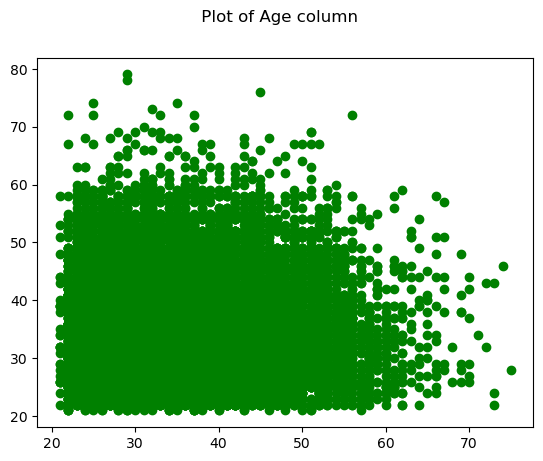

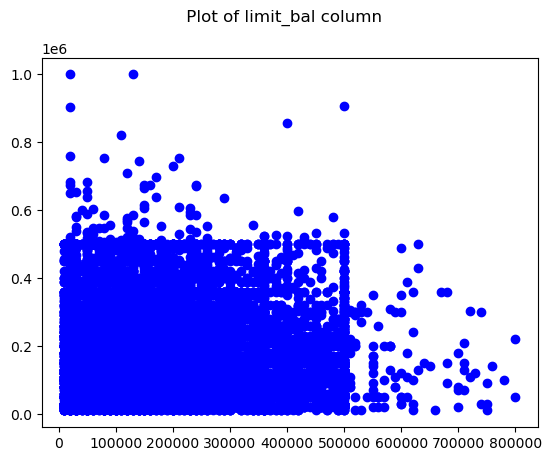

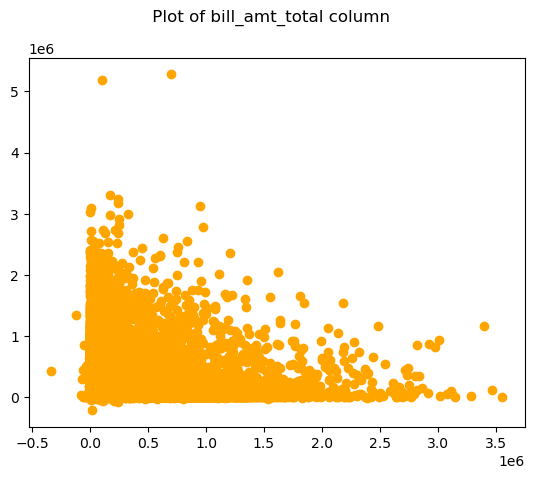

In [66]:
import matplotlib.pyplot as plt

x = validation_data['age']
y = nogan_synth_data['age']

plt.suptitle(" Plot of Age column")
plt.scatter(x, y,c='green')
plt.show()

x = validation_data['limit_bal']
y = nogan_synth_data['limit_bal']

plt.suptitle(" Plot of limit_bal column")
plt.scatter(x, y,c='blue')
plt.show()

plt.suptitle(" Plot of bill_amt_total column")
x = validation_data['bill_amt_total']
y = nogan_synth_data['bill_amt_total']

plt.scatter(x, y,c='orange')
plt.show()



##### Plot the proportion of rows per target in Synthetic & Validation 

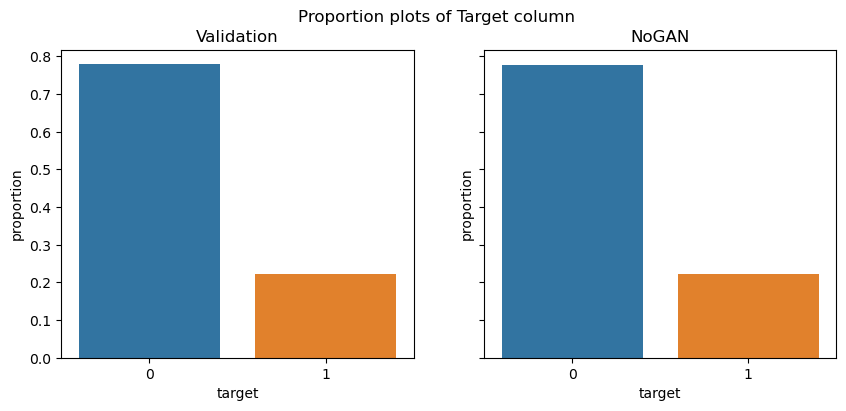

In [67]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
orig_label = validation_data['target'].value_counts(normalize = True).reset_index()
tr_label = nogan_synth_data['target'].value_counts(normalize = True).reset_index()

sns.barplot(data = orig_label, x = "target", y = "proportion", ax = ax[0],label = "validation")
ax[0].set_title("Validation")
sns.barplot(data = tr_label, x = "target", y = "proportion",  ax = ax[1], label = "NoGAN")
ax[1].set_title("NoGAN")

plt.suptitle("Proportion plots of Target column")
plt.show()

### It is evident that there are clear overlap in data population between NoGAN Synthetci data vs Validation data

## Predictive Analytics for Target column using Classification Model for Orginal vs Synthetic vs Augmented data (Original + Synthetic)

In [68]:
from sklearn.calibration import  calibration_curve,CalibrationDisplay
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.preprocessing import  PowerTransformer, Normalizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [83]:
df_real = pd.read_csv("data/UCI_Credit_Card.csv",encoding_errors="ignore")
df_real.columns = df_real.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
df_real.columns = df_real.columns.str.replace('default.payment.next.month', 'target')
df_real.head()

synth_data = pd.read_csv("nogan_synth_data_v1.csv",encoding_errors="ignore")
synth_data.columns = synth_data.columns.str.lower().str.replace("[/,\t,(,),']","", regex = True).str.replace(" ", "_")
synth_data.pop(synth_data.columns[0])

0            0
1            1
2            2
3            3
4            4
         ...  
14995    14995
14996    14996
14997    14997
14998    14998
14999    14999
Name: unnamed:_0, Length: 15000, dtype: int64

In [84]:
augmented_data = pd.concat([df_real, synth_data], ignore_index=True, sort=False)

In [85]:
from sklearn.utils import shuffle
augmented_data = shuffle(augmented_data)

In [79]:
df_real.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,1,"20,000.0000",2,2,1,24,2,2,-1,-1,...,0.0000,0.0000,0.0000,0.0000,689.0000,0.0000,0.0000,0.0000,0.0000,1
1,2,"120,000.0000",2,2,2,26,-1,2,0,0,...,"3,272.0000","3,455.0000","3,261.0000",0.0000,"1,000.0000","1,000.0000","1,000.0000",0.0000,"2,000.0000",1
2,3,"90,000.0000",2,2,2,34,0,0,0,0,...,"14,331.0000","14,948.0000","15,549.0000","1,518.0000","1,500.0000","1,000.0000","1,000.0000","1,000.0000","5,000.0000",0
3,4,"50,000.0000",2,2,1,37,0,0,0,0,...,"28,314.0000","28,959.0000","29,547.0000","2,000.0000","2,019.0000","1,200.0000","1,100.0000","1,069.0000","1,000.0000",0
4,5,"50,000.0000",1,2,1,57,-1,0,-1,0,...,"20,940.0000","19,146.0000","19,131.0000","2,000.0000","36,681.0000","10,000.0000","9,000.0000",689.0000,679.0000,0


In [82]:
synth_data.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,24329,"30,000.0000",1,2,1,38,0,0,-1,-1,...,"5,951.1189","1,658.4015",0.0000,"1,500.0000","5,825.4930","5,966.9161","1,687.6442",0.0000,0.0000,1
1,24414,"30,000.0000",1,2,1,38,0,0,-1,-1,...,"5,789.7544","1,669.0516",0.0000,"1,500.0000","5,961.5674","5,879.0709","1,682.8677",0.0000,0.0000,1
2,15488,"200,000.0000",1,2,1,42,0,0,-1,-1,...,580.2632,577.6367,621.7539,662.2213,503.6770,558.9756,559.8180,580.7133,563.3442,1
3,4761,"30,000.0000",2,1,2,46,-1,-1,-1,2,...,"13,582.2509","16,068.4876","16,296.4649","1,222.4782","1,221.2781",468.6327,"3,642.8294",587.1020,0.0000,1
4,15169,"360,000.0000",2,1,1,27,-1,-1,-1,-1,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1


In [77]:
augmented_data.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target,unnamed:_0
17119,17120,"300,000.0000",2,3,2,27,0,0,0,0,...,"122,914.0000","125,910.0000","9,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000",0,NaN
13295,13296,"20,000.0000",1,2,1,28,0,0,0,0,...,"19,842.0000","19,965.0000","1,358.0000","1,230.0000",617.0000,776.0000,"1,000.0000","4,000.0000",0,NaN
13626,13627,"40,000.0000",1,2,1,48,0,0,-1,-1,...,571.0000,"1,735.0000",0.0000,836.0000,836.0000,571.0000,"2,000.0000",0.0000,0,NaN
6242,6243,"50,000.0000",1,2,2,25,0,0,0,0,...,"18,687.0000","18,033.0000","4,788.0000","1,532.0000","1,002.0000","1,006.0000","2,004.0000","2,309.0000",0,NaN
24691,24692,"70,000.0000",1,2,1,45,0,0,0,0,...,"35,205.0000","37,466.0000","3,000.0000","1,500.0000","3,000.0000","5,000.0000","3,000.0000","5,000.0000",0,NaN


In [72]:
# algorithms group

rfclf = RandomForestClassifier()
lr = LogisticRegression()
xgb = XGBClassifier()
ada_boost = AdaBoostClassifier()

classifiers  = {

    'AdaboostClassifier': ada_boost,
    'RandomForestClassifier' : rfclf,
    'LogisticRegression' :lr,
    'XGBClassifier' : xgb
}

In [73]:
def best_model_selection(df,AUC=False, calibration_curve=False):
    algorithms = []
    mse_test =[]   
    accuracy_on_test=[]
    accuracy_on_train = []

    
    X_train,X_test, y_train,y_test = train_test_split(df.drop(['target'],axis=1), df[['target']], test_size=0.25,random_state=42)
    for obj, model in classifiers.items():
        algorithms.append(obj)
        model.fit(X_train,y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        accuracy_on_train.append(accuracy_score(y_train,train_pred))
        accuracy_on_test.append(accuracy_score(y_test, test_pred))

        mse_test.append(mean_squared_error(y_test,test_pred))
    score_data = {
        'Algorithm' : algorithms,
        'Accuracy(Train)' : accuracy_on_train,
        'Accurcy(Test)' : accuracy_on_test,
        'Test accuracy(MSE)' : mse_test,
    }
    score_df = pd.DataFrame(score_data)
    print(classification_report(test_pred, y_test))
    print(confusion_matrix(test_pred, y_test))
 
        
    return score_df

In [74]:
score_df = best_model_selection(df_real)
score_df

C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.84      0.89      6539
           1       0.36      0.61      0.45       961

    accuracy                           0.81      7500
   macro avg       0.65      0.73      0.67      7500
weighted avg       0.86      0.81      0.83      7500

[[5499 1040]
 [ 374  587]]


,Algorithm,Accuracy(Train),Accurcy(Test),Test accuracy(MSE)
0,AdaboostClassifier,0.8186,0.8181,0.1819
1,RandomForestClassifier,1.0000,0.8172,0.1828
2,LogisticRegression,0.7773,0.7831,0.2169
3,XGBClassifier,0.8956,0.8115,0.1885


In [75]:
score_df = best_model_selection(nogan_synth_data)
score_df

C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.89      0.92      3074
           1       0.61      0.76      0.67       676

    accuracy                           0.87      3750
   macro avg       0.77      0.82      0.79      3750
weighted avg       0.88      0.87      0.87      3750

[[2742  332]
 [ 165  511]]


,Algorithm,Accuracy(Train),Accurcy(Test),Test accuracy(MSE)
0,AdaboostClassifier,0.8282,0.8181,0.1819
1,RandomForestClassifier,1.0000,0.8568,0.1432
2,LogisticRegression,0.7778,0.7749,0.2251
3,XGBClassifier,0.9799,0.8675,0.1325


In [86]:
score_df = best_model_selection(augmented_data)
score_df

C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\EVS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.95      0.86      0.90      9699
           1       0.45      0.74      0.56      1551

    accuracy                           0.84     11250
   macro avg       0.70      0.80      0.73     11250
weighted avg       0.88      0.84      0.85     11250

[[8305 1394]
 [ 407 1144]]


,Algorithm,Accuracy(Train),Accurcy(Test),Test accuracy(MSE)
0,AdaboostClassifier,0.8207,0.8162,0.1838
1,RandomForestClassifier,1.0000,0.8452,0.1548
2,LogisticRegression,0.7795,0.7744,0.2256
3,XGBClassifier,0.9056,0.8399,0.1601


### It is evident that Model performance increases when synthetic data is added to the real data 
#### Random Forest on Real Data = 0.8172
#### Random Forest on Augmented Data = 0.8452

### Summarizing Final Metrics

In [108]:
data_metric = {'Metrics': ['SDV Similarity score', 'Overall Quality Metrics', 'KS Statistics'],
        'Original_Data vs NoGAN_Synthetic_Data': ['95.73%', '93.11%', '18.38%'],
        'Original Data vs SDV_Synthetic_Data': ['92.38%', '91.38%', '24.21%'],
        'Original Data vs SMOTE_Synthetic_Data': ['94.72%', '92.37%', '21.33%'],
        'Original Data vs CTGAN_synth_data': ['86.68%', '94.28%', '33.01%'],
        'Original Data vs data_Ydata': ['98.01%', '98.09%', '2.03%'],
        'Original Data vs data_GRETEL': ['89.72%', '94.82%', '8.27%'],}
 
# Create DataFrame
df = pd.DataFrame(data_metric)
 
# Print the output.
df.head()

,Metrics,Original_Data vs NoGAN_Synthetic_Data,Original Data vs SDV_Synthetic_Data,Original Data vs SMOTE_Synthetic_Data,Original Data vs CTGAN_synth_data,Original Data vs data_Ydata,Original Data vs data_GRETEL
0,SDV Similarity score,95.73%,92.38%,94.72%,86.68%,98.01%,89.72%
1,Overall Quality Metrics,93.11%,91.38%,92.37%,94.28%,98.09%,94.82%
2,KS Statistics,18.38%,24.21%,21.33%,33.01%,2.03%,8.27%


### Conclusion
#### 1) NoGAN has outperform in above similarity Quality Metrics
#### 2) Cross Validation result and scatter plots also depicts close similarity quotient between Validation vs NoGAN Synthetic Data
#### 3) Larger training set improved the ML Model prediction - It is evident in Random Forest classifier result where score increases
#### from .81 to .84 when synthetic data was augmented to original data